# Описание

- Задача: 
1. Посмотреть на компетенции студентов в разрезе желаемой роли в проекте. 
2. Составить словарик технологий для роли
3. Получить удельный вес технологии для роли (как доп признак при распределении по командам)
4. Выделить ключевые технологии внутри роли
- Ожидаемый результат: map(компетенция-роль)
- Вывод:

# План исследования

1. Подготовка данных
2. Исследование данных: оценка корреляции данных
3. Кластеризация данных
4. Оценка компетенций для роли?
5. Посмотреть роли в кот "хочу участвовать" и "Интересно попробовать"

# TODO:
1. дропать списки технологий, не относящихся к роли

# Вопросы

1. Есть ли трендовые технологии?
2. Есть ли отклонения или несоответствия в технологиях внутри одной роли? 
3. Есть ли разделяемость внутри узких ролей

# Возникшие вопросы:
1. Рассматривать роли с максимальным приоритетом или все неотрицательные? 

In [1]:
import pandas as pd
import re

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [5]:
from sklearn.decomposition import PCA

In [6]:
df = pd.read_excel("data_reassembled_5.xlsx")
df.head()

,Отметка времени,"Единая учетная запись СПбГУ (например, ST000000)","Выберете интересующие Вас роли, в IT [Бизнес и системный анализ]","Выберете интересующие Вас роли, в IT [Дизайн UX / UI и проектирование интерфейсов]","Выберете интересующие Вас роли, в IT [Анализ и инженерия данных]","Выберете интересующие Вас роли, в IT [Backend - разработка]","Выберете интересующие Вас роли, в IT [Frontend - разработка]","Выберете интересующие Вас роли, в IT [Тестирование и обеспечение качества]","Выберете интересующие Вас роли, в IT [Развертывание и внедрение]","Выберете интересующие Вас роли, в IT [Управление командой / проектом]",...,Оцените Ваш уровень мотивации [Устроиться на интересную для себя работу],"Хотите ли Вы общаться с другими студентами и выпускниками, заинтересованными в развитии в области IT на базе СПбГУ на интересующие Вас темы?","Что Вам поможет развиваться быстрее в том направлении деятельности, которое Вы выбрали?",Year,Season,score,hard_skills_score,soft_skills_score,directions,roles
0,2023-10-07 16:02:10.676,ST110311,3,1,1.0,1,1,3,1,3,...,3,2,NaN,2023,Осень,7.4,2.8,4.6,"['Web', 'NLP']",[]
1,2023-10-02 16:23:02.340,ST063118,1,3,1.0,5,3,3,3,3,...,4,1,"Опытные наставники, интересные задачи",2023,Осень,8.2,4.8,3.4,"['Time Series', 'DS', 'Robotics']",['backend developer']
2,2023-09-15 19:00:59.596,ST114946,1,3,1.0,3,5,3,1,1,...,3,2,Чёткий план действий,2023,Осень,8.3,4.7,3.6,"['CV', 'DS']",['frontend developer']
3,2023-09-11 14:35:19.227,ST112047,3,3,3.0,1,1,3,1,5,...,6,1,Прежний опыт в написанию проектов и любовь к р...,2023,Осень,8.5,3.5,5.0,"['Web', 'NLP', 'Robotics']",['pm']
4,2023-09-10 22:04:15.396,ST112471,1,1,1.0,1,1,3,1,5,...,1,1,Личный рост,2023,Осень,4.6,0.0,4.6,[],['pm']


In [7]:
tech_columns = [
    'Языки программирования (например: C++, Python, Java, etc)',
    'Библиотеки и фреймворки для различных направлений использования (например: Qt, Numpy, Weka, Angular, PyTorch, etc)',
    'Инструменты для проектирования, бизнес и системного анализа (например: BPMN, UML, Archimate, ARIS etc)',
    'Инструменты для разработки ПО - например: VS Code, PyCharm, Git, etc)',
    'Инструменты для тестирования  (например: GTests, Selenium, Gatling, pytest etc)',
    'Инструменты CI / CD (например: Jenkins, Travis CI, Docker, etc)',
    'Инструменты для управления проектами (например: Jira, Trello, MS Project, etc) '
]

In [8]:
role_columns = [
    'Выберете интересующие Вас роли, в  IT [Бизнес и системный анализ]', 
    'Выберете интересующие Вас роли, в  IT [Дизайн UX / UI и проектирование интерфейсов]',
    'Выберете интересующие Вас роли, в  IT [Анализ и инженерия данных]', 
    'Выберете интересующие Вас роли, в  IT [Backend - разработка]', 
    'Выберете интересующие Вас роли, в  IT [Frontend - разработка]',
    'Выберете интересующие Вас роли, в  IT [Тестирование и обеспечение качества]',
    'Выберете интересующие Вас роли, в  IT [Развертывание и внедрение]',
    'Выберете интересующие Вас роли, в  IT [Управление командой / проектом]',
    'roles'
]

In [9]:
new_df = df[[
    'Единая учетная запись СПбГУ (например, ST000000)',
    'Языки программирования (например: C++, Python, Java, etc)',
    'Библиотеки и фреймворки для различных направлений использования (например: Qt, Numpy, Weka, Angular, PyTorch, etc)',
    'Инструменты для проектирования, бизнес и системного анализа (например: BPMN, UML, Archimate, ARIS etc)',
    'Инструменты для разработки ПО - например: VS Code, PyCharm, Git, etc)',
    'Инструменты для тестирования  (например: GTests, Selenium, Gatling, pytest etc)',
    'Инструменты CI / CD (например: Jenkins, Travis CI, Docker, etc)',
    'Инструменты для управления проектами (например: Jira, Trello, MS Project, etc) ',
    'Выберете интересующие Вас роли, в  IT [Бизнес и системный анализ]', 
    'Выберете интересующие Вас роли, в  IT [Дизайн UX / UI и проектирование интерфейсов]',
    'Выберете интересующие Вас роли, в  IT [Анализ и инженерия данных]', 
    'Выберете интересующие Вас роли, в  IT [Backend - разработка]', 
    'Выберете интересующие Вас роли, в  IT [Frontend - разработка]',
    'Выберете интересующие Вас роли, в  IT [Тестирование и обеспечение качества]',
    'Выберете интересующие Вас роли, в  IT [Развертывание и внедрение]',
    'Выберете интересующие Вас роли, в  IT [Управление командой / проектом]',
    'roles'
]]


In [11]:
# Разделение строк на отдельные термины и получение уникальных значений
unique_roles = set()
for row in new_df['roles']:
    terms = eval(row) # strip("[]").replace("'", "").split(', ') 
    unique_roles.update(terms)

print(unique_roles)

{'implementation', 'ux/ui', 'backend developer', 'system or business analyst', 'qa', 'frontend developer', 'da or de', 'pm'}


In [12]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 17 columns):
 #   Column                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                              --------------  -----  
 0   Единая учетная запись СПбГУ (например, ST000000)                                                                    349 non-null    object 
 1   Языки программирования (например: C++, Python, Java, etc)                                                           346 non-null    object 
 2   Библиотеки и фреймворки для различных направлений использования (например: Qt, Numpy, Weka, Angular, PyTorch, etc)  309 non-null    object 
 3   Инструменты для проектирования, бизнес и системного анализа (например: BPMN, UML, Archimate, ARIS etc)              106 non-null    object 
 4   Инструменты для разр

In [13]:
# new_df['Выберете интересующие Вас роли, в  IT [Анализ и инженерия данных]'] = new_df['Выберете интересующие Вас роли, в  IT [Анализ и инженерия данных]'].astype('int64')

In [14]:
new_df.loc[:, tech_columns] = new_df.loc[:, tech_columns].astype(str)


/var/folders/89/q6t8y6z56vl91ct9zt_gb56h0000gn/T/ipykernel_80312/3231379370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.loc[:, tech_columns] = new_df.loc[:, tech_columns].astype(str)


### добавление признаков - TODO: проверить функцию

In [15]:
from functions_for_clustering import *
tech_df = collect_competency_matrix(new_df, tech_columns)

In [16]:
# # список, в котором будут храниться все уникальные технологии из разных файлов
# all_technologies = []

# # Пройдемся по всем файлам и добавим уникальные технологии в список
# file_paths = ["languages.txt", "frameworks.txt", "analysis_tools.txt", "CI_CD.txt", "dev_tools.txt",  "project_management_tools.txt"]
# for file_path in file_paths:
#     with open(file_path, "r") as file:
#         technologies = file.read().splitlines()
        
#         all_technologies.extend(technologies)

# # Удалить дубликаты 
# all_technologies = list(set(all_technologies))

# tech_df = pd.DataFrame(columns=all_technologies, index=range(len(new_df)))


# # Создать столбцы для каждой уникальной технологии и заполнить их нулями
# for tech in all_technologies:
#     tech_df[tech] = 0

# def fill_tech_df_with_values(tech_df, column_name: str):
#     for i, response in new_df.iterrows():
#         competence_values = {}  # Создать пустой словарь для хранения значений компетенций студента

#         # Регулярное выражение для извлечения технологий и оценок
#         pattern = r"([a-zA-Z\-\+ # .\d]+) - (\d)" 
        
#         # response_lower = response.lower()
#         response_lower = response[column_name].lower()
#         cleaned_response = response_lower.replace('\n', ',')
#         cleaned_response = cleaned_response.replace('с', 'c')
#         cleaned_response = cleaned_response.replace('c ++', "c++")
#         cleaned_response = cleaned_response.replace('pyhton', 'python')
        
#         # Найти все совпадения в ответе студента
#         matches = re.findall(pattern, cleaned_response)
        
#         if matches:
#             for match in matches:
#                 technology = match[0].strip().lower()
#                 rating = int(match[1])
#                 competence_values[technology] = rating
#                 # print(technology, rating)
            
#             for tech in all_technologies:
#                 if tech_df.at[i, tech] == 0:
#                     tech_df.at[i, tech] = competence_values.get(tech, 0)

# # Применить функцию к каждому столбцу, содержащему данные о технологиях
# for column in tech_columns:  # tech_columns - список названий столбцов с данными о технологиях
#     fill_tech_df_with_values(tech_df, column)   

In [17]:
result_df = pd.concat([new_df, tech_df], axis=1)

In [18]:
result_df.head()

,"Единая учетная запись СПбГУ (например, ST000000)","Языки программирования (например: C++, Python, Java, etc)","Библиотеки и фреймворки для различных направлений использования (например: Qt, Numpy, Weka, Angular, PyTorch, etc)","Инструменты для проектирования, бизнес и системного анализа (например: BPMN, UML, Archimate, ARIS etc)","Инструменты для разработки ПО - например: VS Code, PyCharm, Git, etc)","Инструменты для тестирования (например: GTests, Selenium, Gatling, pytest etc)","Инструменты CI / CD (например: Jenkins, Travis CI, Docker, etc)","Инструменты для управления проектами (например: Jira, Trello, MS Project, etc)","Выберете интересующие Вас роли, в IT [Бизнес и системный анализ]","Выберете интересующие Вас роли, в IT [Дизайн UX / UI и проектирование интерфейсов]",...,yii,spacy,use case,travis cl,robot framework,directx,opevcv,phpmyadmin,assembler,yandex tank
0,ST110311,Python - 2,Numpy - 1,nan,nan,nan,nan,nan,3,1,...,0,0,0,0,0,0,0,0,0,0
1,ST063118,C# - 4\nC - 3\nC++ - 2\nPython - 3,ASP.NET - 4\nBlazor - 4\nNumpy - 3\nQt - 2,,Rider - 4\nGit - 4\nPyCharm - 3\nSVN - 2,,Docker - 4,Trello - 2\nGitLab - 4,1,3,...,0,0,0,0,0,0,0,0,0,0
2,ST114946,C++ - 3\nJava - 3\nC# - 2\nPython - 3\nJavaScr...,Django - 3\nBoost - 3\nQt - 2\nSpring - 3\nMav...,Microsoft Visio - 2\nUML - 2\nSAP - 3\nBPMN - 2,GitHub - 3\nVS Code - 3\nAzure - 2\nDocker - 2...,GTests - 2\nJira - 3 \nGatling - 2,Jenkins - 3\nGitHub actions -2\nGitLab CI - 2,Jira- 3\nMS Project - 2\nJetbrains teamcity - 2,1,3,...,0,0,0,0,0,0,0,0,0,0
3,ST112047,Python 3,Numpy 3,-,-,-,-,-,3,3,...,0,0,0,0,0,0,0,0,0,0
4,ST112471,1,2,1,1,1,Я,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [19]:
result_df.fillna(0, inplace=True)

## Корреляции

In [ ]:
# # Проверка корреляции между двумя колонками
# корреляция = df['Колонка1'].corr(df['Колонка2'])

# print(f"Корреляция между Колонка1 и Колонка2: {корреляция}")

In [ ]:
c = result_df['python'].corr(result_df['Выберете интересующие Вас роли, в  IT [Backend - разработка]'])

print(f"Корреляция между python и Колонка2: {c}")

Корреляция между python и Колонка2: 0.08949323774894616


In [ ]:
d = result_df['python'].corr(result_df['Выберете интересующие Вас роли, в  IT [Анализ и инженерия данных]'])

print(f"Корреляция между python и Колонка2: {d}")

Корреляция между python и Колонка2: 0.17311209318239337


/var/folders/89/q6t8y6z56vl91ct9zt_gb56h0000gn/T/ipykernel_74790/1194253333.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = result_df.corr()


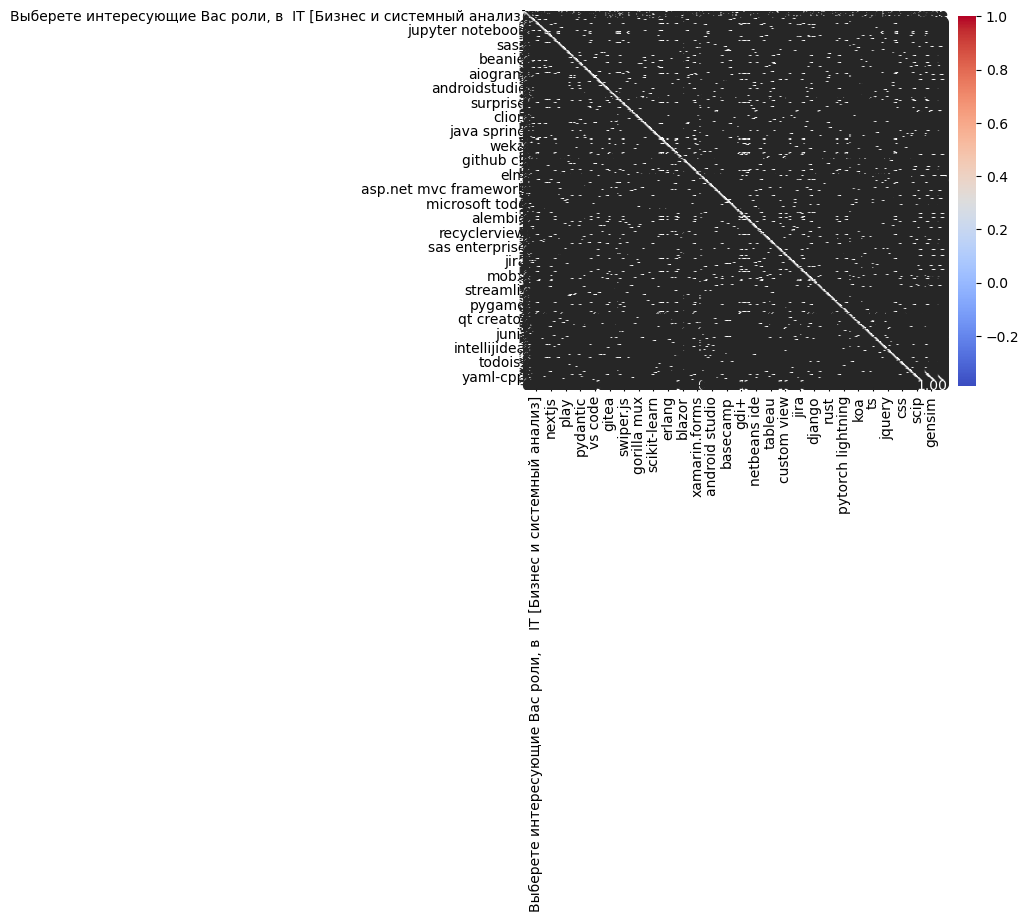

In [ ]:
corr_matrix = result_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [ ]:
corr_matrix_roles = corr_matrix.iloc[:8, 8:]

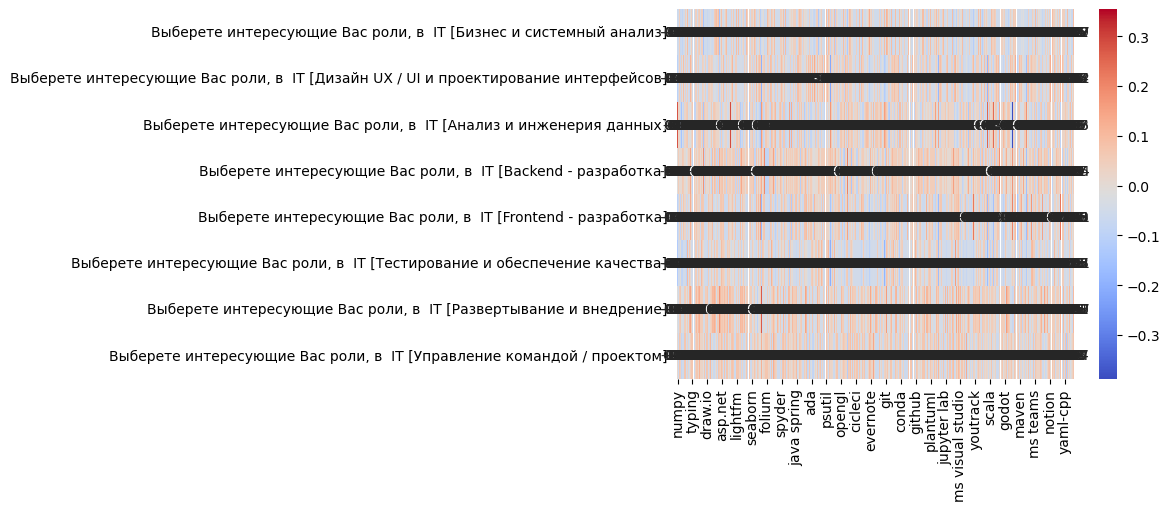

In [ ]:
sns.heatmap(corr_matrix_roles, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [ ]:
corr_matrix_roles.head()

,numpy,mokito,zoom,yandextracker,dart,perl,spring boot,gulp,sqlalhemy,nextjs,...,wireframe,keras,intelijiidea,chrome devtools,bullet,re,beautifulsoup,ruby on rails,gensim,loguru
"Выберете интересующие Вас роли, в IT [Бизнес и системный анализ]",-0.060818,-0.051822,0.043117,-0.073392,-0.017685,-0.062531,-0.090017,-0.051822,-0.051822,0.043117,...,-0.051822,-0.046160,0.090586,-0.051822,-0.051822,0.043117,-0.019227,-0.067428,-0.071959,0.090586
"Выберете интересующие Вас роли, в IT [Дизайн UX / UI и проектирование интерфейсов]",-0.100698,-0.051114,0.042283,-0.072390,0.029930,0.046408,-0.034709,0.088981,-0.051114,0.042283,...,-0.051114,-0.097322,0.042283,0.042283,-0.051114,-0.051114,-0.070976,0.072377,-0.019100,0.042283
"Выберете интересующие Вас роли, в IT [Анализ и инженерия данных]",0.278303,0.026406,0.026406,-0.068714,-0.056266,-0.149352,-0.040896,-0.085980,0.026406,0.026406,...,0.063868,0.026670,0.026406,-0.048518,0.026406,0.063868,0.088687,-0.063130,0.067879,0.026406
"Выберете интересующие Вас роли, в IT [Backend - разработка]",-0.011139,0.051987,0.005225,0.007401,0.027442,0.009077,0.063228,0.051987,0.005225,0.005225,...,-0.088297,0.004858,-0.088297,0.005225,0.051987,0.005225,0.007256,0.067643,-0.044690,0.051987
"Выберете интересующие Вас роли, в IT [Frontend - разработка]",-0.097443,-0.061764,0.025683,-0.087474,0.116202,0.044612,-0.031338,0.069406,0.025683,0.025683,...,-0.061764,0.009845,-0.061764,0.069406,0.025683,-0.061764,-0.085765,0.049672,-0.012908,0.025683


In [ ]:
# путь и имя файла Excel, в который запишем данные
excel_file = 'corr_matrix.xlsx'

# Запись данных в Excel
corr_matrix.to_excel(excel_file)  # Установить index=False, чтобы не сохранять индексы

### Список (знач.корр, строка, столбец)

In [ ]:
def find_great_corr(c_matrix, k=0.5):
    corr_list = []
    for i_row, row_name in c_matrix.iterrows():
        for j_column, v in row_name.items():
            if abs(v) > k and i_row != j_column: 
                # print(v)
                temp = (v, i_row, j_column)
                corr_list.append(temp)
    print("Список значений корреляций:")
    for tuple in corr_list:
        print(tuple) 
    return corr_list

In [ ]:
find_great_corr(corr_matrix_roles, k=0.6)

Список значений корреляций:


[]

In [ ]:
corr_matrix_techs = corr_matrix.iloc[8:, 8:]

In [ ]:
corr_tech_list = find_great_corr(corr_matrix_techs, 0.8)
print(len(corr_tech_list))

Список значений корреляций:
(0.9999999999999994, 'mokito', 'gradle')
(1.0, 'mokito', 'springsecurity')
(0.9999999999999994, 'mokito', 'springweb')
(0.9999999999999994, 'mokito', 'pivotaltracker')
(1.0, 'zoom', 'nextjs')
(1.0, 'zoom', 'storybook')
(1.0000000000000004, 'zoom', 'aiohttp')
(1.0, 'zoom', 'mongoose')
(1.0, 'zoom', 'effector')
(1.0, 'zoom', 'framer-motion')
(1.0000000000000004, 'zoom', 'aio-pika')
(1.0, 'zoom', 'nest js')
(1.0, 'zoom', 'prisma')
(0.8298056338148561, 'dart', 'flutter')
(0.9999999999999999, 'gulp', 'sass')
(1.0, 'gulp', 'reason ml')
(0.8941704679675258, 'gulp', 'express')
(1.0, 'gulp', 'marionette')
(0.9999999999999999, 'gulp', 'less')
(0.9999999999999999, 'gulp', 'emotion')
(1.0, 'gulp', 'svelte')
(1.0, 'gulp', 'elm')
(1.0, 'gulp', 'elixir')
(0.9999999999999999, 'gulp', 'handlebars')
(1.0, 'gulp', 'swift ui')
(1.0, 'gulp', 'ocaml')
(1.0, 'gulp', 'rollup')
(0.9999999999999998, 'gulp', 'mobx')
(0.9999999999999998, 'gulp', 'webpack')
(1.0, 'gulp', 'koa')
(0.99999

In [ ]:
python_corr_list = find_great_corr(pd.DataFrame(corr_matrix_techs['python']), 0.5)
print(len(python_corr_list))

Список значений корреляций:
(0.6990542477889776, 'numpy', 'python')
(0.5526700198023076, 'pycharm', 'python')
2


# Кластеризация в разрезе желаемых ролей

In [157]:
qa_techs = extract_specific_features("test_tools.txt")
sa_ba_techs = extract_specific_features("analysis_tools.txt")
pm_techs = extract_specific_features("project_management_tools.txt")
imp_techs = extract_specific_features("CI_CD.txt")

languages = extract_specific_features("languages.txt")
frameworks = extract_specific_features("frameworks.txt")
dev_tools = extract_specific_features("dev_tools.txt")

## Backend developer

Необходимо рассмотреть все желаемые роли студента или взять максимальную

In [301]:
# Выборка строк, в которых 'backend developer' присутствует в списке ролей
backend_df = result_df[result_df['roles'].str.contains('backend developer')]

backend_df.head()

,"Единая учетная запись СПбГУ (например, ST000000)","Языки программирования (например: C++, Python, Java, etc)","Библиотеки и фреймворки для различных направлений использования (например: Qt, Numpy, Weka, Angular, PyTorch, etc)","Инструменты для проектирования, бизнес и системного анализа (например: BPMN, UML, Archimate, ARIS etc)","Инструменты для разработки ПО - например: VS Code, PyCharm, Git, etc)","Инструменты для тестирования (например: GTests, Selenium, Gatling, pytest etc)","Инструменты CI / CD (например: Jenkins, Travis CI, Docker, etc)","Инструменты для управления проектами (например: Jira, Trello, MS Project, etc)","Выберете интересующие Вас роли, в IT [Бизнес и системный анализ]","Выберете интересующие Вас роли, в IT [Дизайн UX / UI и проектирование интерфейсов]",...,yii,spacy,use case,travis cl,robot framework,directx,opevcv,phpmyadmin,assembler,yandex tank
1,ST063118,C# - 4\nC - 3\nC++ - 2\nPython - 3,ASP.NET - 4\nBlazor - 4\nNumpy - 3\nQt - 2,,Rider - 4\nGit - 4\nPyCharm - 3\nSVN - 2,,Docker - 4,Trello - 2\nGitLab - 4,1,3,...,0,0,0,0,0,0,0,0,0,0
9,ST115982,C# - 4\nC++ - 2\nPython - 2\nJava - 1\nPython ...,Numpy - 2\nPandas - 2\nMatplotlib - 2\nPyTorch...,\n,Visual studio - 4\nUnity - 4\nPycharm - 2\nGit...,\n,\n,\n,1,1,...,0,0,0,0,0,0,0,0,0,0
14,ST110470,"Python - 4,\nJS - 2",AIOgram - 4\nDjango - 4,-,VS Code - 5\nGit -4,pytest - 3/4,Docker - 4,Notion -4,3,1,...,0,0,0,0,0,0,0,0,0,0
17,ST090662,"Python - 3, c++ - 2, c# - 1","FastAPI - 3, Django - 3",nan,"Git - 3, PyCharm - 3",pytest - 2,Docker - 3,Jira - 3,1,1,...,0,0,0,0,0,0,0,0,0,0
19,ST115985,C++ - 3\nPython - 2,Qt - 1\nAngular - 1,nan,Git - 3\nPyCharm - 2\nVS Code - 2,Selenium - 1\nPytest - 1,Jenkins - 3\nDocker - 3,nan,1,1,...,0,0,0,0,0,0,0,0,0,0


In [302]:
# print(new_df.iloc[3])

#### DBSCAN

In [303]:
# backend_df.set_index('Единая учетная запись СПбГУ (например, ST000000)', inplace=True)
backend_df = backend_df.drop(tech_columns, axis=1)
backend_df = backend_df.drop(['Единая учетная запись СПбГУ (например, ST000000)'], axis=1)
backend_df = backend_df.drop(role_columns, axis=1)

drop_set = set (qa_techs + sa_ba_techs+ pm_techs+ imp_techs + dev_tools)
backend_df = backend_df.drop(drop_set, axis=1)
# # backend_df = backend_df.drop(sa_ba_techs, axis=1)
# backend_df = backend_df.drop(pm_techs, axis=1)
# backend_df = backend_df.drop(imp_techs, axis=1)

In [304]:
# backend_df.fillna(0, inplace=True)

In [305]:
# backend_columns = list(languages, frameworks, dev_tools)
# backend_df = backend_df[backend_columns]

In [306]:
backend_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 1 to 343
Columns: 283 entries, numpy to assembler
dtypes: int64(283)
memory usage: 286.2 KB


In [307]:
backend_df.head()

,numpy,ember,j,reactjs,streamlit,uikit,lua,ruby on rails,tortoise,spring mvc,...,rust,opengl,spring,expressjs,diesel-rs,yii,spacy,directx,opevcv,assembler
1,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Чистим от "нулевых" колонок

In [308]:
# Проверяем, какие колонки полностью состоят из нулевых значений
zero_columns = backend_df.columns[backend_df.eq(0).all(axis=0)]

print("Колонки с нулевыми значениями:", zero_columns.tolist())

backend_df = backend_df.drop(zero_columns, axis=1)


Колонки с нулевыми значениями: ['ember', 'j', 'streamlit', 'nemo', 'fragments', 'folium', 'xgboost', 'quill', 'android sdk', 'jquery', 'addressables', 'vulkan', 'wandb', 'prophet', 'implicit', 'gdi+', 'symphony', 'surprise', 'coroutines', 'next', 'reactivex', 'pyav', 'nest js', 'arduino', 'typing', 'hascell', 'material design', 'matematica', 'net', 'rxjava', 'elasticsearch', 'mpandroidchart', 'next.js', 'recyclerview', 'yaml-cpp', 'r', 'flow', 'swiper.js', 'croller', 'razor', 'bumpy', 'mongoose', 'networkx', 'nim', 'play', 'kafka', 'prisma', 'volley', 'pyplot', 'mediapipe', 'spark', 'winforms', 'sanic', 'sdml', 'unity dots', 'boostrap', 'arduino c', 'asp.net mvc framework', 'beautifulsoup', 'geocoder', 'gephi', 'razdel', 'pytorch lightning', 'apispec', 'huggingface', 'firebase', 'antlr', 'npm', 'catboost', 'reactnative', 'nextjs', 'factor', 'rxjs', 'sklearn', 'framer-motion', 'jetpack compose', 're', 'aio-pika', 'storybook', 'ror', 'twint', 'google play console', 'cg', 'd', 'scss', 'nl

In [309]:
data_backend = backend_df.values
data1 = backend_df.values

In [310]:
# # Create a list of eps values to test
# eps_values = np.linspace(0.1, 10.0, 100)

# # Create a list to store inertia values
# inertia_values = []

# # Iterate over eps values and compute the inertia for each
# for eps in eps_values:
#     dbscan = DBSCAN(eps=eps, min_samples=5)
#     cluster_labels = dbscan.fit_predict(data)
#     # Compute some metric for evaluating the quality of clustering (e.g., inertia)
#     # In this example, I'll use the sum of squared distances from points to their cluster centers
#     # Note: This is not an official DBSCAN metric, just for demonstration
#     cluster_centers = np.array([np.mean(data[cluster_labels == label], axis=0) for label in np.unique(cluster_labels)])
#     distances = np.sum((data - cluster_centers[cluster_labels]) ** 2, axis=1)
#     inertia = np.sum(distances)
#     inertia_values.append(inertia)

# # Plot the elbow method graph
# plt.figure(figsize=(8, 8))
# plt.plot(eps_values, inertia_values, marker='o', linestyle='-')
# plt.xlabel('Eps Value')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Eps Selection')
# plt.grid(True)
# plt.show()

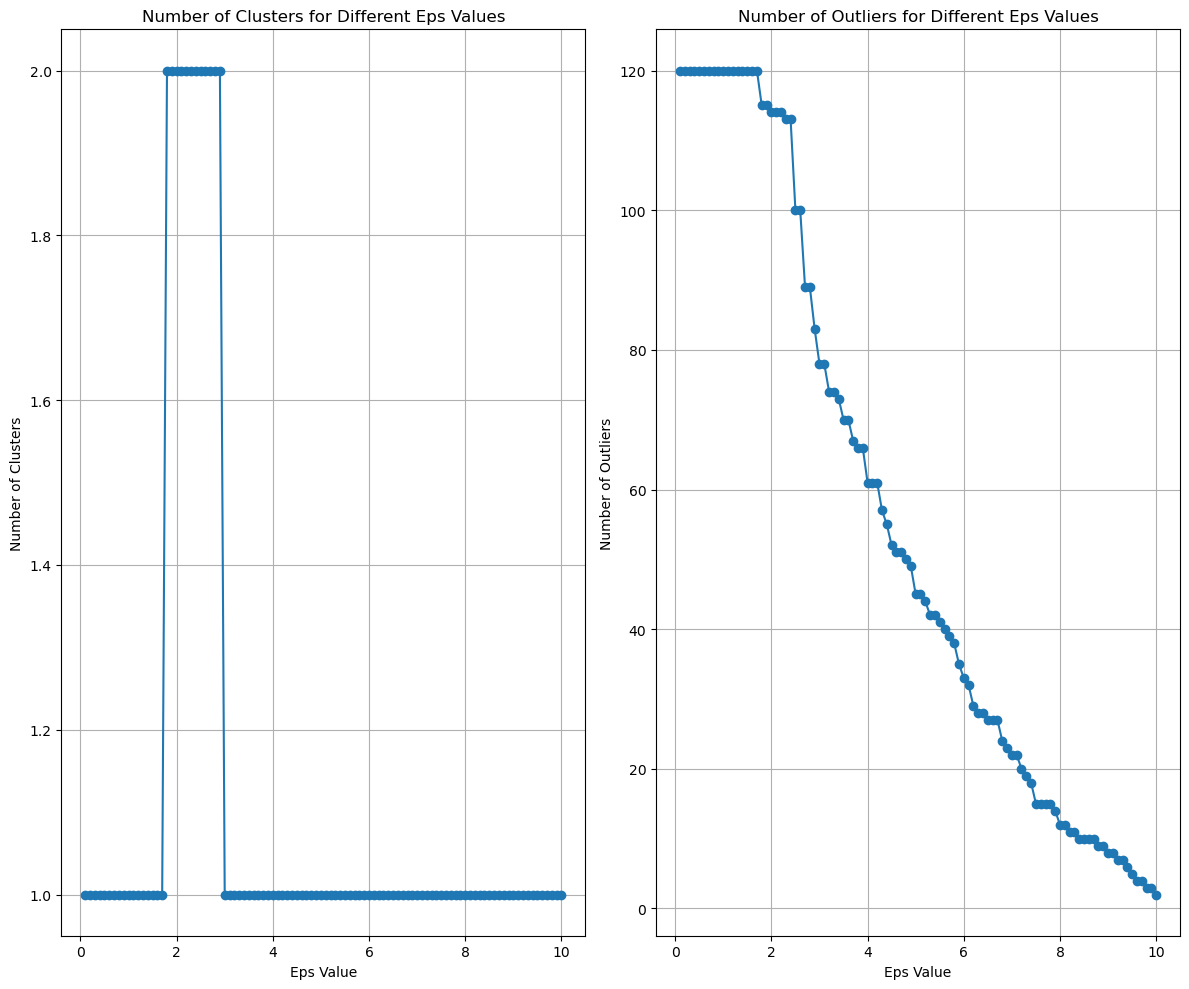

In [311]:
find_parameters_for_DBSCUN(0.1, 10.0, 100, data_backend)

In [312]:
# # Create a list of eps values to test
# eps_values = np.linspace(0.1, 10.0, 100)

# # Create lists to store the number of clusters and outlier counts for each eps value
# n_clusters_values = []
# n_outliers_values = []

# # Iterate over eps values and compute the number of clusters and outliers for each
# for eps in eps_values:
#     dbscan = DBSCAN(eps=eps, min_samples=5)
#     cluster_labels = dbscan.fit_predict(data)
    
#     # Count the number of clusters (excluding outliers, which are labeled as -1)
#     n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    
#     # Count the number of outliers (points labeled as -1)
#     n_outliers = np.sum(cluster_labels == -1)
    
#     n_clusters_values.append(n_clusters)
#     n_outliers_values.append(n_outliers)

# # Plot the number of clusters and outliers for each eps value
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.plot(eps_values, n_clusters_values, marker='o', linestyle='-')
# plt.xlabel('Eps Value')
# plt.ylabel('Number of Clusters')
# plt.title('Number of Clusters for Different Eps Values')
# plt.grid(True)

# plt.subplot(1, 2, 2)
# plt.plot(eps_values, n_outliers_values, marker='o', linestyle='-')
# plt.xlabel('Eps Value')
# plt.ylabel('Number of Outliers')
# plt.title('Number of Outliers for Different Eps Values')
# plt.grid(True)

# plt.tight_layout()
# plt.show()

2 кластера + много выбросов

In [313]:
dbscan = DBSCAN(eps=4, min_samples=5)
dbscan.fit(data_backend)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

In [314]:
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 1


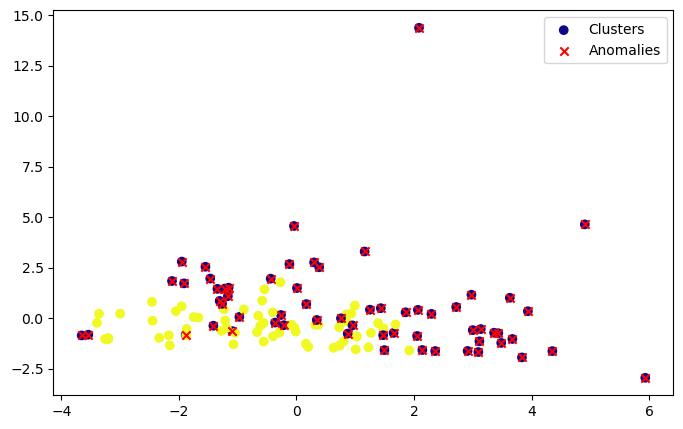

In [315]:
draw_clusters(data_backend, cluster_labels, is_anomaly)

In [316]:
# # Применяем PCA для уменьшения размерности до двух компонент
# pca = PCA(n_components=2)
# data_2d = pca.fit_transform(data)

# # Отображаем точки кластеров на графике
# plt.figure(figsize=(8, 5))
# plt.scatter(data_2d[:, 0], data_2d[:, 1], c=cluster_labels, cmap='plasma', label='Clusters')

# # Отображаем аномальные точки на графике
# plt.scatter(data_2d[is_anomaly][:, 0], data_2d[is_anomaly][:, 1], c='red', marker='x', label='Anomalies') 

# plt.legend()
# plt.show()

In [317]:
count_points_in_clusters(cluster_labels)

Кластер 0: 68 точек
Кластер -1: 61 точек


In [318]:
# # Используем словарь для подсчета количества точек в каждом кластере
# cluster_counts = {}
# for label in set(cluster_labels):
#     # if label == -1:
#     #     continue  # Пропустить выбросы
#     cluster_counts[label] = np.sum(cluster_labels == label)

# # Выводим количество точек в каждом кластере
# for label, count in cluster_counts.items():
#     print(f"Кластер {label}: {count} точек")

In [319]:
# # Пример использования функции
# data = ...  # исходные данные (матрица данных)
# cluster_labels = ...  # Метки кластеров, полученные после кластеризации
# all_technologies = ...  # Названия всех колонок

analyze_clusters(data1, cluster_labels, backend_df.columns)

Кластер -1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['fastapi', 'c++', 'sas enterprise', 'sas', 'assembler'], dtype='object')

Кластер 0:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['numpy', 'c#', 'java', 'c++', 'python'], dtype='object')



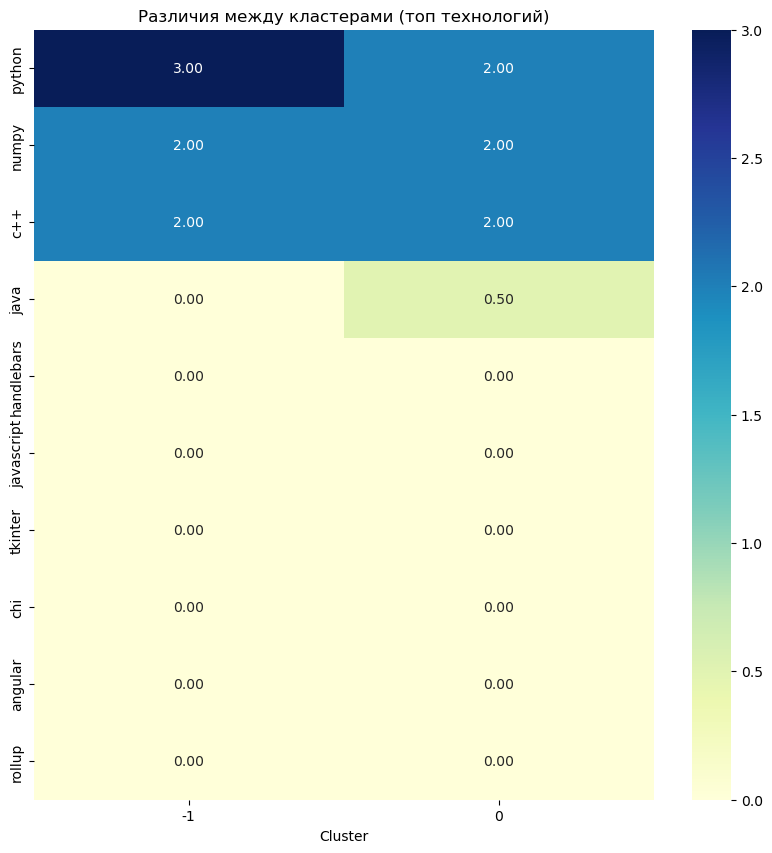

In [320]:
draw_heat_map(data_backend, backend_df.columns, cluster_labels)

In [321]:
# # Создать DataFrame из данных с метками кластеров
# clustered_data = pd.DataFrame(data, columns=backend_df.columns)
# clustered_data['Cluster'] = cluster_labels

# clustered_data = pd.DataFrame(data, columns=backend_df.columns)
# clustered_data['Cluster'] = cluster_labels

# # clustered_data - это DataFrame с данными, 'Cluster' - это название колонки с метками кластеров

# # Подсчитать количество элементов в каждом кластере
# cluster_counts = clustered_data['Cluster'].value_counts()

# # Отфильтровать только кластеры, в которых количество элементов больше или равно 5
# valid_clusters = cluster_counts[cluster_counts >= 4].index

# # Создать новый DataFrame только с данными из выбранных кластеров
# filtered_clustered_data = clustered_data[clustered_data['Cluster'].isin(valid_clusters)]


In [322]:
# # Вычислить средние значения для каждого кластера - медиана
# cluster_means = filtered_clustered_data.groupby('Cluster').median() # mean()  # sum()  # median() 

# # Выбрать топ-10 технологий с наибольшими средними значениями
# top_10_technologies = cluster_means.max().sort_values(ascending=False).index[:10]

# # Отфильтровать данные по выбранным топ-10 технологиям
# cluster_means_filtered = cluster_means[top_10_technologies]

# # Создать тепловую карту различий
# plt.figure(figsize=(10, 10))
# sns.heatmap(cluster_means_filtered.T, annot=True, cmap='YlGnBu', fmt='.2f')
# plt.title('Различия между кластерами (топ-10 технологий)')
# plt.show()

**Вывод**: Python, c++, java 

### Аномалии - скиловые студенты

In [323]:
backend_anomalies = backend_df[is_anomaly]
backend_anomalies.head()

,numpy,reactjs,uikit,lua,ruby on rails,tortoise,spring mvc,ts,springsecurity,retrofit,...,tensorflow,asp.net,rust,opengl,spring,expressjs,diesel-rs,yii,spacy,assembler
1,3,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
35,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0
40,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Убираю 'python', 'c++', 'git', 'pycharm', 'numpy', потому что они мешают находить различия между группами

In [324]:
# backend_anomalies = backend_anomalies.drop(['python', 'c++', 'git', 'pycharm', 'numpy'], axis=1) 
# backend_anomalies = backend_anomalies.drop(dev_tools, axis=1)

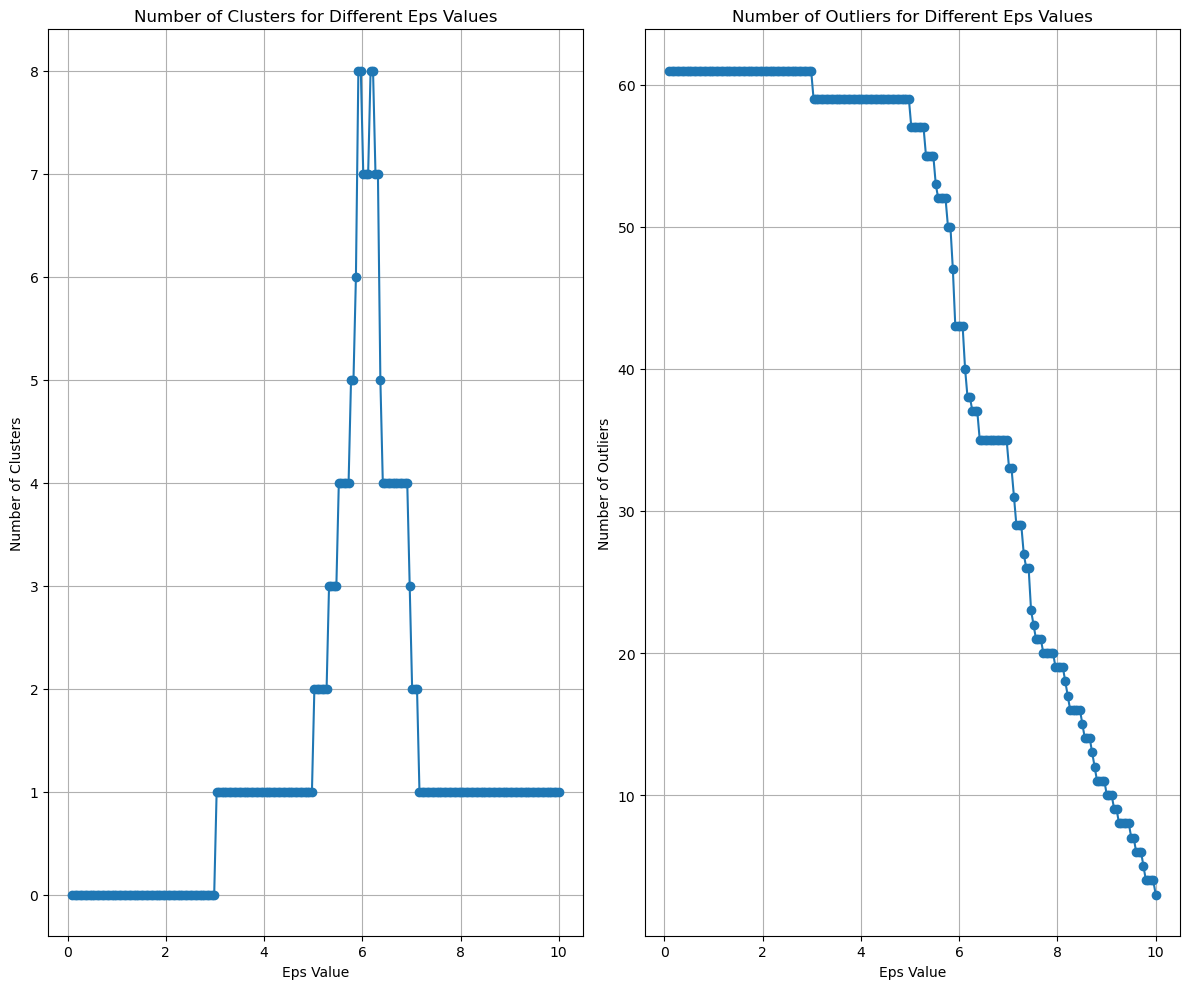

In [325]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, backend_anomalies, 2)

In [326]:
dbscan = DBSCAN(eps=6.2, min_samples=2)
dbscan.fit(backend_anomalies)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 8


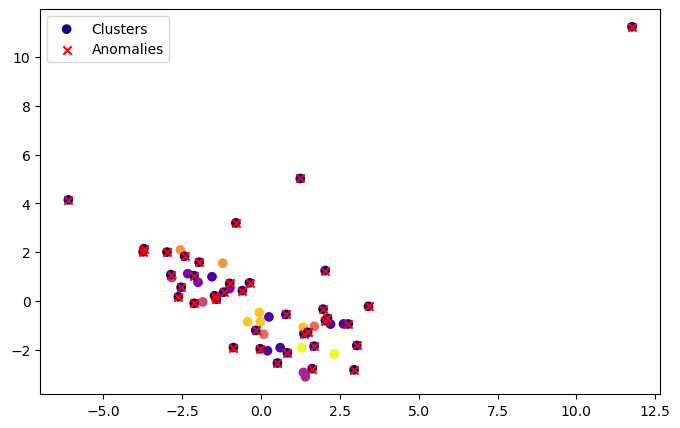

In [327]:
draw_clusters(backend_anomalies, cluster_labels, is_anomaly)

In [328]:
count_points_in_clusters(cluster_labels)

Кластер 0: 6 точек
Кластер 1: 3 точек
Кластер 2: 2 точек
Кластер 3: 2 точек
Кластер 4: 2 точек
Кластер 5: 2 точек
Кластер 6: 4 точек
Кластер 7: 2 точек
Кластер -1: 38 точек


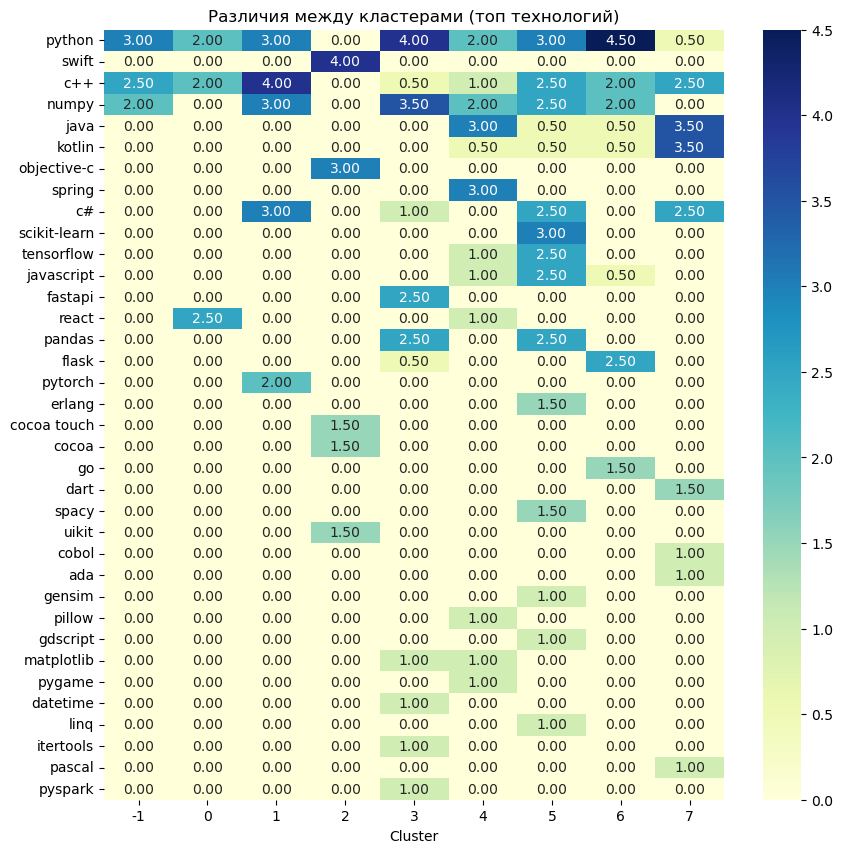

In [329]:
draw_heat_map(backend_anomalies, backend_anomalies.columns, cluster_labels, 36)

Вывод по Backend-разработке: 

# DA or DE

In [584]:
# Выборка строк, в которых 'da or de' присутствует в списке ролей
da_de_df = result_df[result_df['roles'].str.contains('da or de')]

da_de_df.head()

,"Единая учетная запись СПбГУ (например, ST000000)","Языки программирования (например: C++, Python, Java, etc)","Библиотеки и фреймворки для различных направлений использования (например: Qt, Numpy, Weka, Angular, PyTorch, etc)","Инструменты для проектирования, бизнес и системного анализа (например: BPMN, UML, Archimate, ARIS etc)","Инструменты для разработки ПО - например: VS Code, PyCharm, Git, etc)","Инструменты для тестирования (например: GTests, Selenium, Gatling, pytest etc)","Инструменты CI / CD (например: Jenkins, Travis CI, Docker, etc)","Инструменты для управления проектами (например: Jira, Trello, MS Project, etc)","Выберете интересующие Вас роли, в IT [Бизнес и системный анализ]","Выберете интересующие Вас роли, в IT [Дизайн UX / UI и проектирование интерфейсов]",...,yii,spacy,use case,travis cl,robot framework,directx,opevcv,phpmyadmin,assembler,yandex tank
5,ST069808,Python - 4\nPHP - 3\nJava - 2\nC++ - 2\nC# - 2,Numpy - 3\nPyTorch - 2\nscipy - 3,UML - 3,PyCharm - 4\nGit - 4,pytest - 2,Docker - 3,Jira - 3,3,1,...,0,0,0,0,0,0,0,0,0,0
16,ST077125,C++ - 2\nPython - 2\nSQL - 2,Numpy- 2\nPandas - 2,nan,Git - 2\nPyCharm - 2\nVisual Studio - 2,nan,nan,Trello - 3,1,1,...,0,0,0,0,0,0,0,0,0,0
19,ST115985,C++ - 3\nPython - 2,Qt - 1\nAngular - 1,nan,Git - 3\nPyCharm - 2\nVS Code - 2,Selenium - 1\nPytest - 1,Jenkins - 3\nDocker - 3,nan,1,1,...,0,0,0,0,0,0,0,0,0,0
31,ST069636,Python - 5,Numpy - 5\nPyTorch - 4\nPandas - 5\nPlotly - 4...,nan,VS Code - 5\nGit - 4,Pytest - 3,Docker - 3,Trello - 3\nAsana - 3,1,1,...,0,0,0,0,0,0,0,0,0,0
36,ST095276,С++ - 2\nJava - 2\nPython - 3\nSQL - 2\n,Numpy - 3\nPandas - 4\nMatplotlib - 3\nSeaborn...,nan,VS Code - 4\nGit - 3,GTests - 2\n,Docker - 1\n,nan,5,3,...,0,0,0,0,0,0,0,0,0,0


In [585]:
da_de_df = da_de_df.drop(tech_columns, axis=1)
da_de_df = da_de_df.drop(['Единая учетная запись СПбГУ (например, ST000000)'], axis=1)
da_de_df = da_de_df.drop(role_columns, axis=1)

# Проверяем, какие колонки полностью состоят из нулевых значений
zero_columns = da_de_df.columns[da_de_df.eq(0).all(axis=0)]

print("Колонки с нулевыми значениями:", zero_columns.tolist())
da_de_df = da_de_df.drop(zero_columns, axis=1)

Колонки с нулевыми значениями: ['capybara', 'ember', 'j', 'reactjs', 'greenplum', 'gitlab ci', 'uikit', 'lua', 'ruby on rails', 'tortoise', 'spring mvc', 'jupyter-notebook', 'ts', 'springsecurity', 'retrofit', 'fragments', 'decker', 'ruby', 'make', 'stryker', 'fltk', 'gradle', 'quill', 'phpstorm', 'azure', 'tokio-rs', 'intellj idea', 'blazor', 'tableau', 'anaconda jupyter notebook', 'jquery', 'addressables', 'kibana', 'microsoft azure', 'vulkan', 'clap-rs', 'springweb', 'brackets', 'jetbrains', 'linq', 'puppeteer', 'github actions', 'cocoa', 'symphony', 'pytest-xdist', 'coroutines', 'next', 'gohit', 'rayon', 'nest js', 'svelte', 'heroku', 'weka', 'redux', 'rider', 'wakatime', 'hascell', 'material design', 'matematica', 'net', 'aiogram', 'vim', 'sentry', 'karma', '.', 'android espresso', 'math', 'qtcreator', 'mindmeister', 'koa', 'rxjava', 'faker', 'vue.js', 'dependency-injector', 'hadoop', 'telegram', 'eclipse', 'nightwatch', 'webpack', 'mpandroidchart', 'next.js', 'vue', 'recyclerview

In [586]:
data_da_de = da_de_df.values

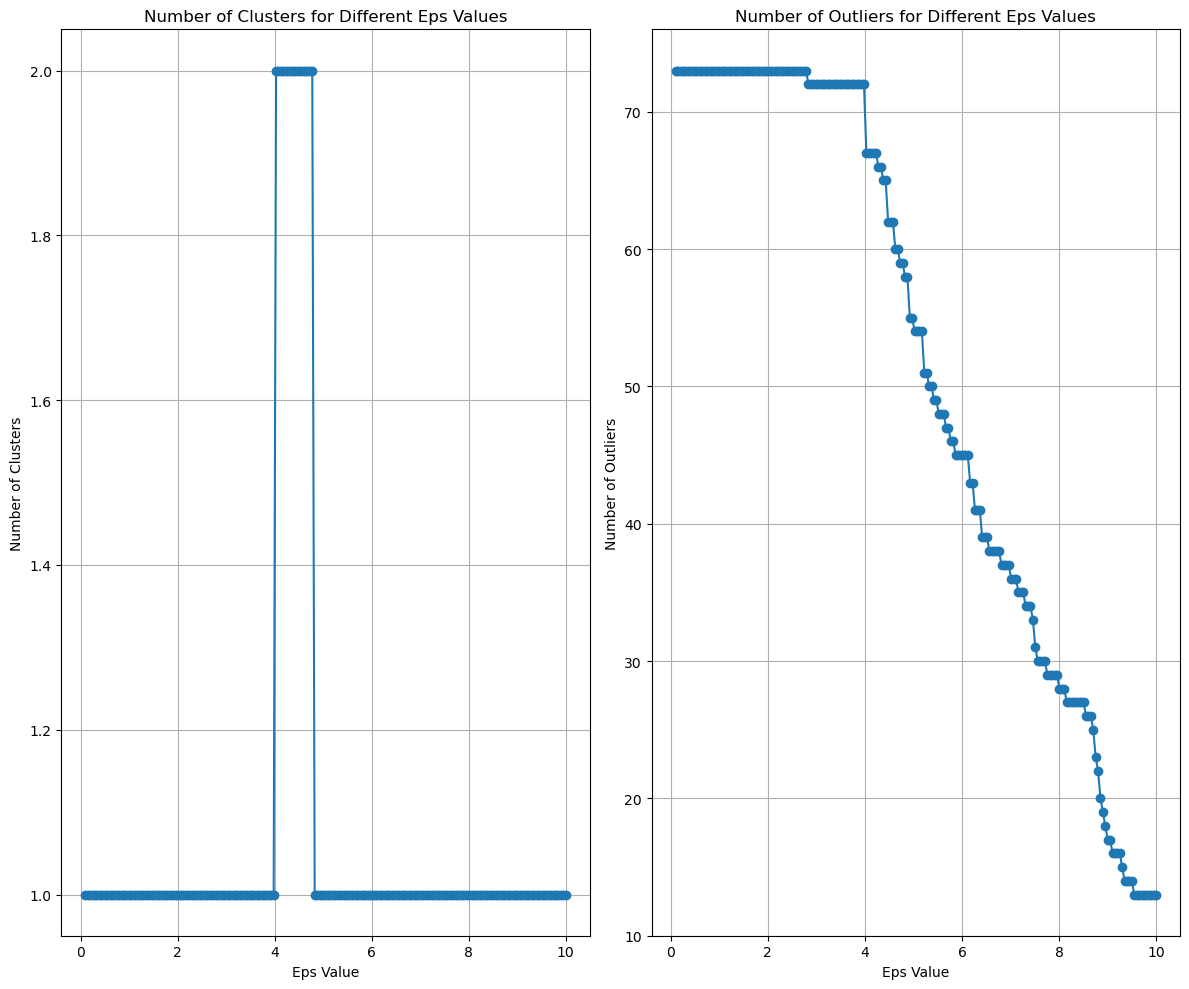

In [587]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, data_da_de, 5)

In [588]:
# # Create a list of eps values to test
# eps_values = np.linspace(0.1, 10.0, 200)

# # Create lists to store the number of clusters and outlier counts for each eps value
# n_clusters_values = []
# n_outliers_values = []

# # Iterate over eps values and compute the number of clusters and outliers for each
# for eps in eps_values:
#     dbscan = DBSCAN(eps=eps, min_samples=5)
#     cluster_labels = dbscan.fit_predict(data_da_de)
    
#     # Count the number of clusters (excluding outliers, which are labeled as -1)
#     n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    
#     # Count the number of outliers (points labeled as -1)
#     n_outliers = np.sum(cluster_labels == -1)
    
#     n_clusters_values.append(n_clusters)
#     n_outliers_values.append(n_outliers)

# # Plot the number of clusters and outliers for each eps value
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.plot(eps_values, n_clusters_values, marker='o', linestyle='-')
# plt.xlabel('Eps Value')
# plt.ylabel('Number of Clusters')
# plt.title('Number of Clusters for Different Eps Values')
# plt.grid(True)

# plt.subplot(1, 2, 2)
# plt.plot(eps_values, n_outliers_values, marker='o', linestyle='-')
# plt.xlabel('Eps Value')
# plt.ylabel('Number of Outliers')
# plt.title('Number of Outliers for Different Eps Values')
# plt.grid(True)

# plt.tight_layout()
# plt.show()

In [589]:
dbscan = DBSCAN(eps=4.1, min_samples=5)
dbscan.fit(data_da_de)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

In [590]:
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 2


In [591]:
# def draw_clusters(data, cluster_labels, is_anomaly):
#     # Применяем PCA для уменьшения размерности до двух компонент
#     pca = PCA(n_components=2)
#     data_2d = pca.fit_transform(data)

#     # Отображаем точки кластеров на графике
#     plt.figure(figsize=(8, 5))
#     plt.scatter(data_2d[:, 0], data_2d[:, 1], c=cluster_labels, cmap='plasma', label='Clusters')

#     # Отображаем аномальные точки на графике
#     plt.scatter(data_2d[is_anomaly][:, 0], data_2d[is_anomaly][:, 1], c='red', marker='x', label='Anomalies') 

#     plt.legend()
#     plt.show()

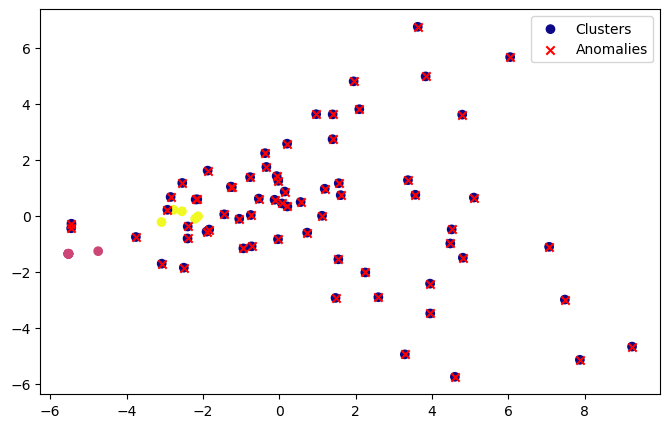

In [592]:
from functions_for_clustering import *  # draw_clusters

draw_clusters(data_da_de, cluster_labels, is_anomaly)

In [593]:
# def count_points_in_clusters(cluster_labels):
#     # Используем словарь для подсчета количества точек в каждом кластере
#     cluster_counts = {}
#     for label in set(cluster_labels):
#         # if label == -1:
#         #     continue  # Пропустить выбросы
#         cluster_counts[label] = np.sum(cluster_labels == label)

#     # Выводим количество точек в каждом кластере
#     for label, count in cluster_counts.items():
#         print(f"Кластер {label}: {count} точек")

In [594]:
count_points_in_clusters(cluster_labels)

Кластер 0: 9 точек
Кластер 1: 5 точек
Кластер -1: 67 точек


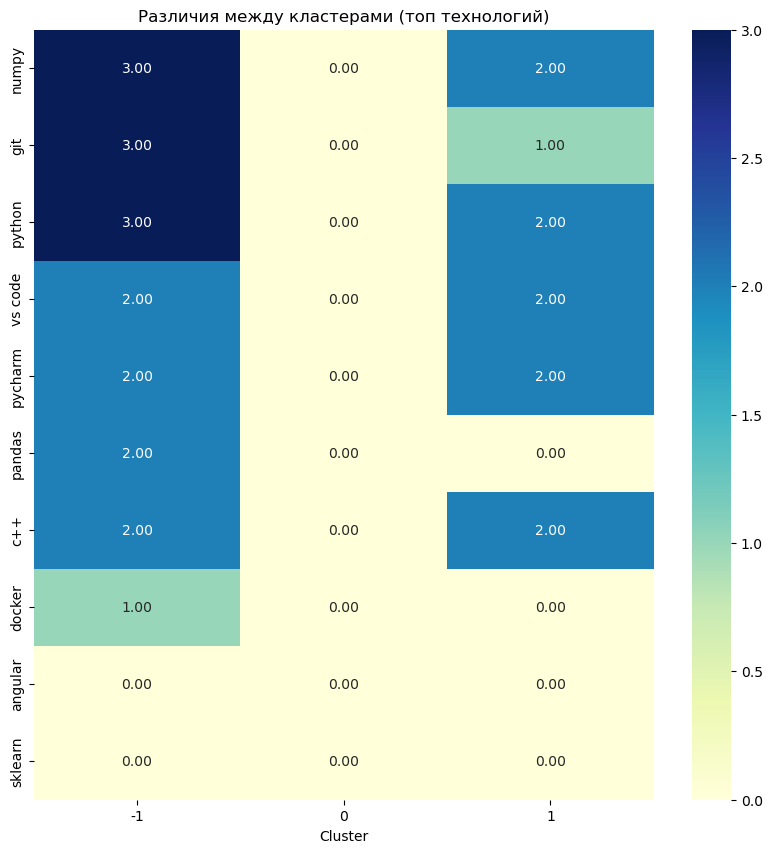

In [595]:
draw_heat_map(data_da_de, da_de_df.columns, cluster_labels)

Вывод по DS+DA: 

In [596]:
# # Создать DataFrame из данных с метками кластеров
# clustered_data = pd.DataFrame(data_da_de, columns=da_de_df.columns)
# clustered_data['Cluster'] = cluster_labels

# clustered_data = pd.DataFrame(data_da_de, columns=da_de_df.columns)
# clustered_data['Cluster'] = cluster_labels

# # clustered_data - это DataFrame с данными, 'Cluster' - это название колонки с метками кластеров

# # Подсчитать количество элементов в каждом кластере
# cluster_counts = clustered_data['Cluster'].value_counts()

# # Отфильтровать только кластеры, в которых количество элементов больше или равно 5
# valid_clusters = cluster_counts[cluster_counts >= 4].index

# # Создать новый DataFrame только с данными из выбранных кластеров
# filtered_clustered_data = clustered_data[clustered_data['Cluster'].isin(valid_clusters)]

In [597]:
# # Вычислить средние значения для каждого кластера - медиана
# cluster_means = filtered_clustered_data.groupby('Cluster').median() # mean()  # sum()  # median() 

# # Выбрать топ-10 технологий с наибольшими средними значениями
# top_10_technologies = cluster_means.max().sort_values(ascending=False).index[:10]

# # Отфильтровать данные по выбранным топ-10 технологиям
# cluster_means_filtered = cluster_means[top_10_technologies]

# # Создать тепловую карту различий
# plt.figure(figsize=(10, 10))
# sns.heatmap(cluster_means_filtered.T, annot=True, cmap='YlGnBu', fmt='.2f')
# plt.title('Различия между кластерами (топ-10 технологий)')
# plt.show()

## DA/DS anomalies

In [598]:
da_de_anomalies = da_de_df[is_anomaly]
da_de_anomalies.head()

,numpy,android studio,streamlit,nemo,jupyter notebook,evernote,visual studio,matlab,django,folium,...,js,wpf,kotlin,asp.net core,tensorflow,intellij idea,kubernetes,rust,opengl,spring
5,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


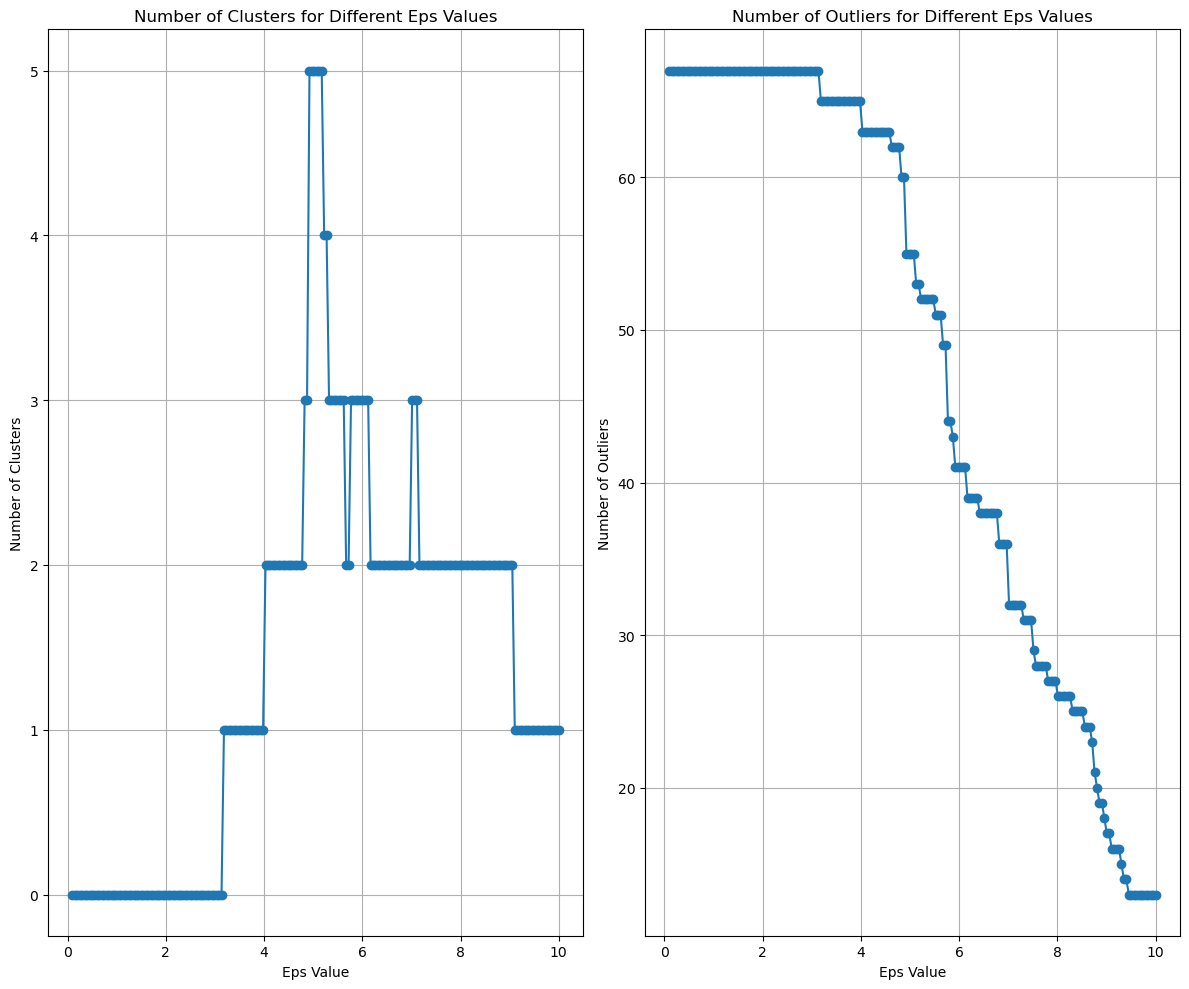

In [599]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, da_de_anomalies, 2)


In [600]:
dbscan = DBSCAN(eps=5, min_samples=2)
dbscan.fit(da_de_anomalies)
# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_
# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 5


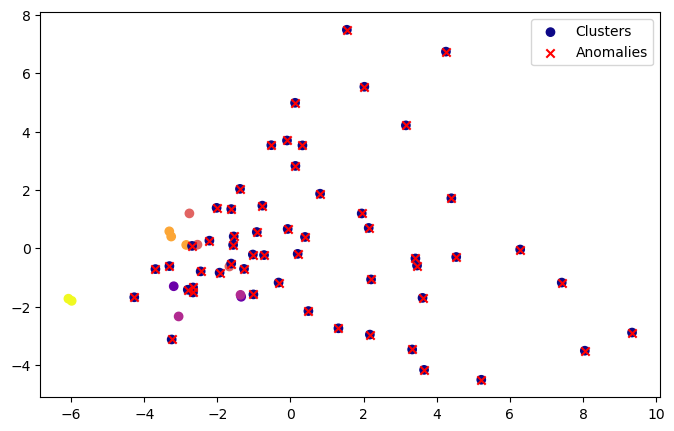

In [601]:
draw_clusters(da_de_anomalies, cluster_labels, is_anomaly)

In [602]:
count_points_in_clusters(cluster_labels)

Кластер 0: 2 точек
Кластер 1: 2 точек
Кластер 2: 3 точек
Кластер 3: 3 точек
Кластер 4: 2 точек
Кластер -1: 55 точек


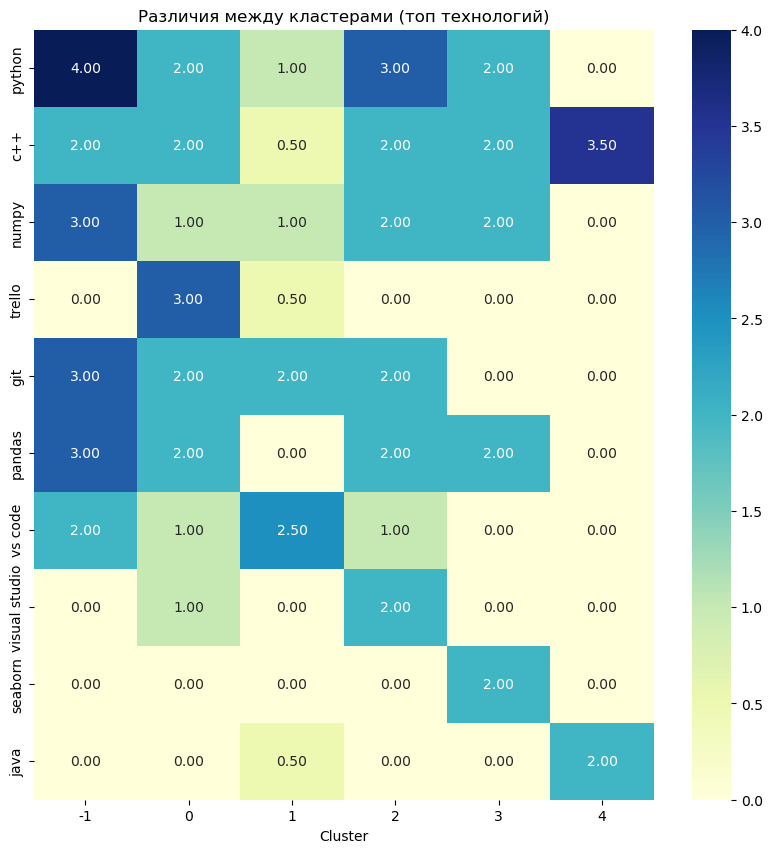

In [603]:
draw_heat_map(da_de_anomalies, da_de_anomalies.columns, cluster_labels)


**Вывод по DA/DS**: 

# Frontend developer

In [604]:
# Выборка строк, в которых 'frontend developer' присутствует в списке ролей
frontend_df = result_df[result_df['roles'].str.contains('frontend developer')]

frontend_df.head()

,"Единая учетная запись СПбГУ (например, ST000000)","Языки программирования (например: C++, Python, Java, etc)","Библиотеки и фреймворки для различных направлений использования (например: Qt, Numpy, Weka, Angular, PyTorch, etc)","Инструменты для проектирования, бизнес и системного анализа (например: BPMN, UML, Archimate, ARIS etc)","Инструменты для разработки ПО - например: VS Code, PyCharm, Git, etc)","Инструменты для тестирования (например: GTests, Selenium, Gatling, pytest etc)","Инструменты CI / CD (например: Jenkins, Travis CI, Docker, etc)","Инструменты для управления проектами (например: Jira, Trello, MS Project, etc)","Выберете интересующие Вас роли, в IT [Бизнес и системный анализ]","Выберете интересующие Вас роли, в IT [Дизайн UX / UI и проектирование интерфейсов]",...,yii,spacy,use case,travis cl,robot framework,directx,opevcv,phpmyadmin,assembler,yandex tank
2,ST114946,C++ - 3\nJava - 3\nC# - 2\nPython - 3\nJavaScr...,Django - 3\nBoost - 3\nQt - 2\nSpring - 3\nMav...,Microsoft Visio - 2\nUML - 2\nSAP - 3\nBPMN - 2,GitHub - 3\nVS Code - 3\nAzure - 2\nDocker - 2...,GTests - 2\nJira - 3 \nGatling - 2,Jenkins - 3\nGitHub actions -2\nGitLab CI - 2,Jira- 3\nMS Project - 2\nJetbrains teamcity - 2,1,3,...,0,0,0,0,0,0,0,0,0,0
6,ST068144,"Typescript, React, Python\nTypescript, Javascr...","React, Numpy\nReact",UML (чуть-чуть)\nUML,"VS Code, Git, Atlassian\nVS Code, Git, GitLab,...",Jest\nJest,Docker\nDocker,Jira\nJira,1,1,...,0,0,0,0,0,0,0,0,0,0
26,ST095279,C++ - 3\nJavaScript - 3\nHTML - 3\nCss - 3\nDa...,React - 3\nFlutter - 3,nan,VS Code - 4,nan,Docker - 2,nan,1,1,...,0,0,0,0,0,0,0,0,0,0
27,ST062087,C# - 3\nPython - 2\nJava - 2\nC++ - 2,Pandas - 2\nNumpy - 2,UML - 1,Git - 3\nIntelliJ IDEA - 2\nVS - 2,GTests - 2,nan,Jira - 2,3,3,...,0,0,0,0,0,0,0,0,0,0
29,ST105895,С++ - 4\nPython - 2,Vue - 1\nNumpy - 2\nPandas - 2\nAsio - 1,nan,VS code - 3\nVisual Studio - 4\nGit - 4,nan,nan,nan,3,1,...,0,0,0,0,0,0,0,0,0,0


In [605]:
frontend_df = frontend_df.drop(tech_columns, axis=1)
frontend_df = frontend_df.drop(['Единая учетная запись СПбГУ (например, ST000000)'], axis=1)
frontend_df = frontend_df.drop(role_columns, axis=1)
frontend_df = frontend_df.drop(['python', 'c++', 'git', 'pycharm', 'numpy', 'vscode', 'visual studio', 'vs code', 'trello', 'jira', 'docker', 'pandas', 'slack', 'notion'], axis=1) 


In [606]:
# Проверяем, какие колонки полностью состоят из нулевых значений
zero_columns = frontend_df.columns[frontend_df.eq(0).all(axis=0)]

print("Колонки с нулевыми значениями:", zero_columns.tolist())

frontend_df = frontend_df.drop(zero_columns, axis=1)

data_frontend = frontend_df.values

Колонки с нулевыми значениями: ['capybara', 'j', 'streamlit', 'greenplum', 'uikit', 'tortoise', 'spring mvc', 'jupyter-notebook', 'nemo', 'evernote', 'springsecurity', 'fragments', 'decker', 'make', 'gradle', 'folium', 'xgboost', 'quill', 'android sdk', 'intellj idea', 'blazor', 'gdal', 'tableau', 'anaconda jupyter notebook', 'addressables', 'kibana', 'vulkan', 'wandb', 'springweb', 'prophet', 'jetbrains', 'implicit', 'wsgiref', 'gitlab-ci', 'github actions', 'gdi+', 'vmwareworkstation', 'ef core', 'symphony', 'pytest-xdist', 'pyspark', 'surprise', 'coroutines', 'jupyter lab', 'next', 'googlecolab', 'reactivex', 'gohit', 'pyav', 'razor pages', 'nest js', 'weka', 'arduino', 'typing', 'hascell', 'material design', 'matematica', 'net', 'sentry', '.', 'ms teams', 'android espresso', 'qtcreator', 'junit', 'mindmeister', 'rxjava', 'scip', 'faker', 'pillow', 'dependency-injector', 'telegram', 'elasticsearch', 'mpandroidchart', 'recyclerview', 'rspec', 'intelij idea', 'conda', 'sublime text', 

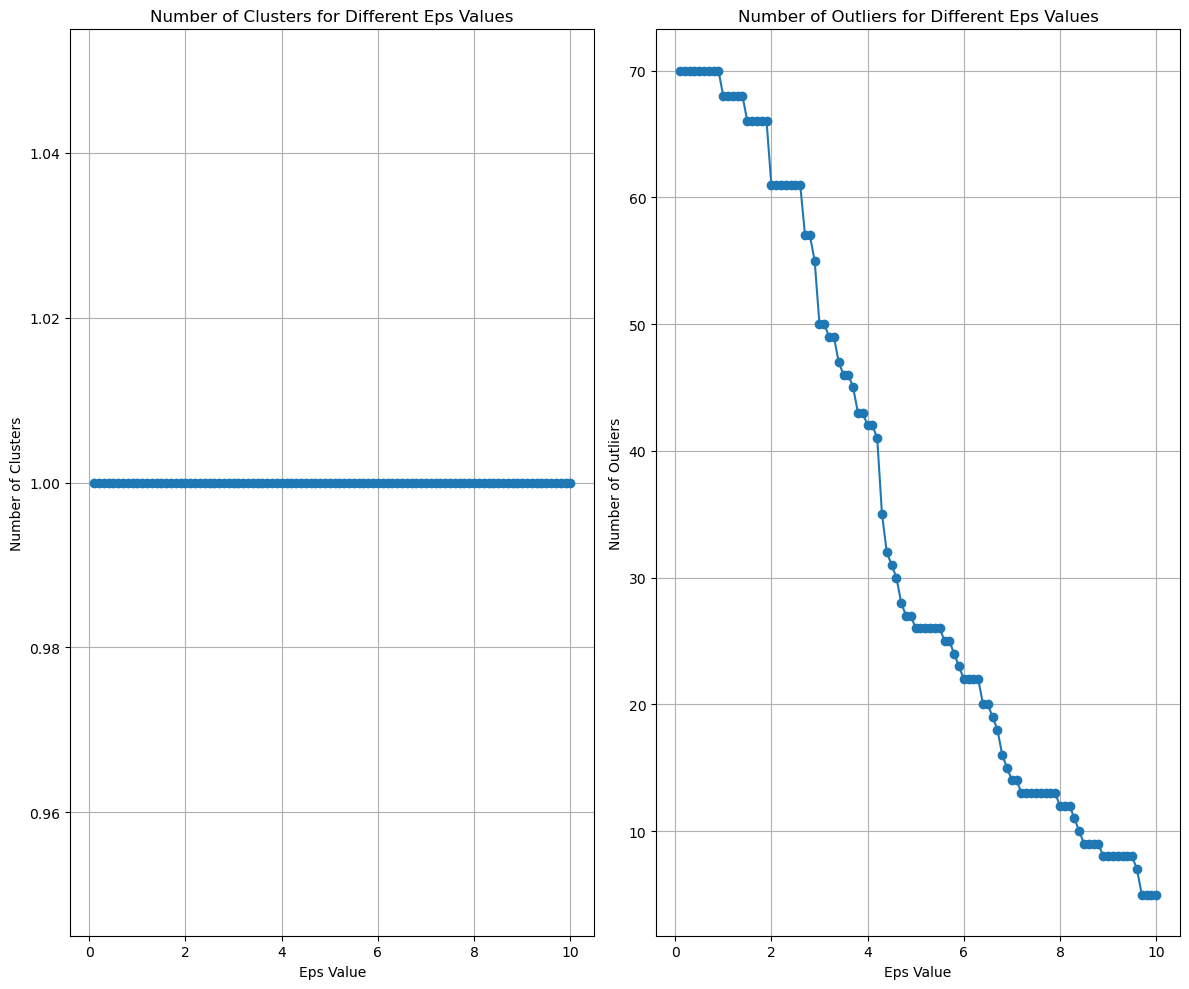

In [607]:
find_parameters_for_DBSCUN(0.1, 10.0, 100, data_frontend)

3.3 - 3 кластера + 183 выброса

In [608]:
dbscan = DBSCAN(eps=3.8, min_samples=5)
dbscan.fit(data_frontend)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

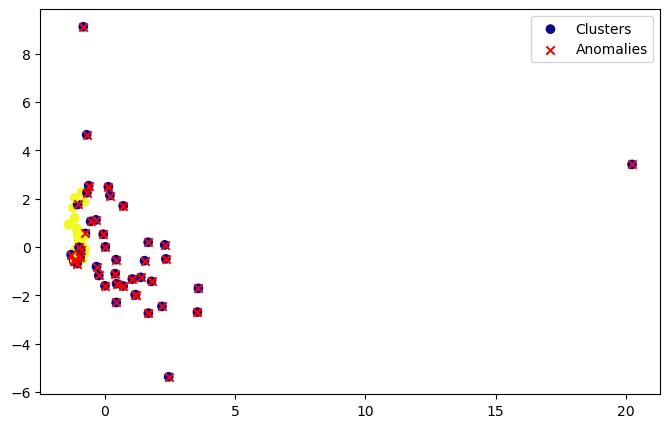

In [610]:
draw_clusters(data_frontend, cluster_labels, is_anomaly)

In [611]:
count_points_in_clusters(cluster_labels)

Кластер 0: 36 точек
Кластер -1: 43 точек


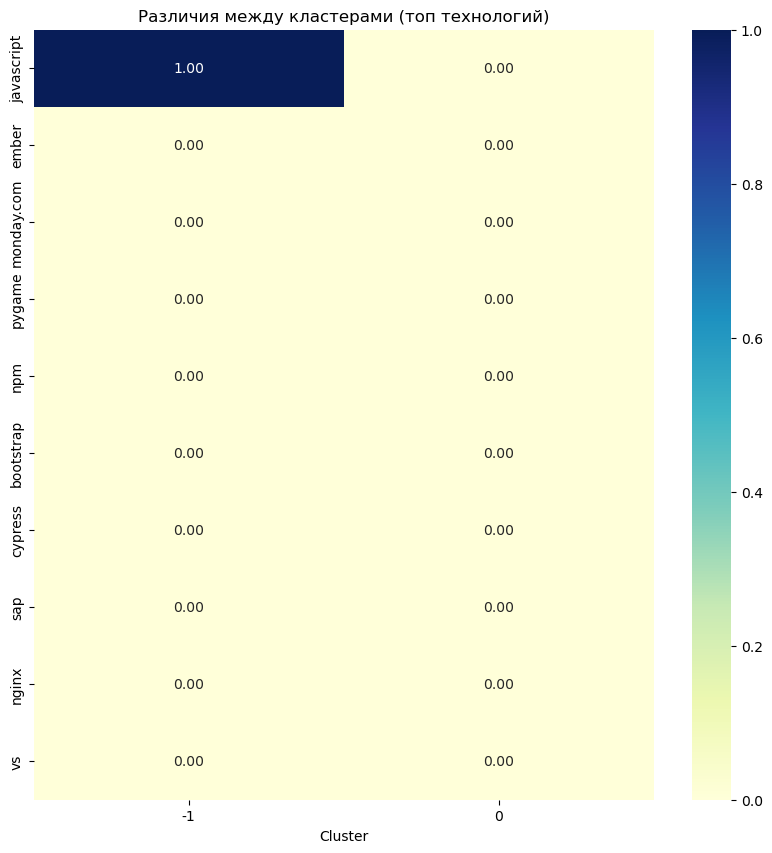

In [612]:
draw_heat_map(data_frontend, frontend_df.columns, cluster_labels)

## frontend anomalies

In [613]:
frontend_anomalies = frontend_df[is_anomaly]
frontend_anomalies.head()

,ember,android studio,reactjs,gitlab ci,lua,ruby on rails,jupyter notebook,ts,retrofit,ruby,...,kotlin,tensorflow,intellij idea,asp.net,teamcity,rust,spring,expressjs,diesel-rs,spacy
2,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


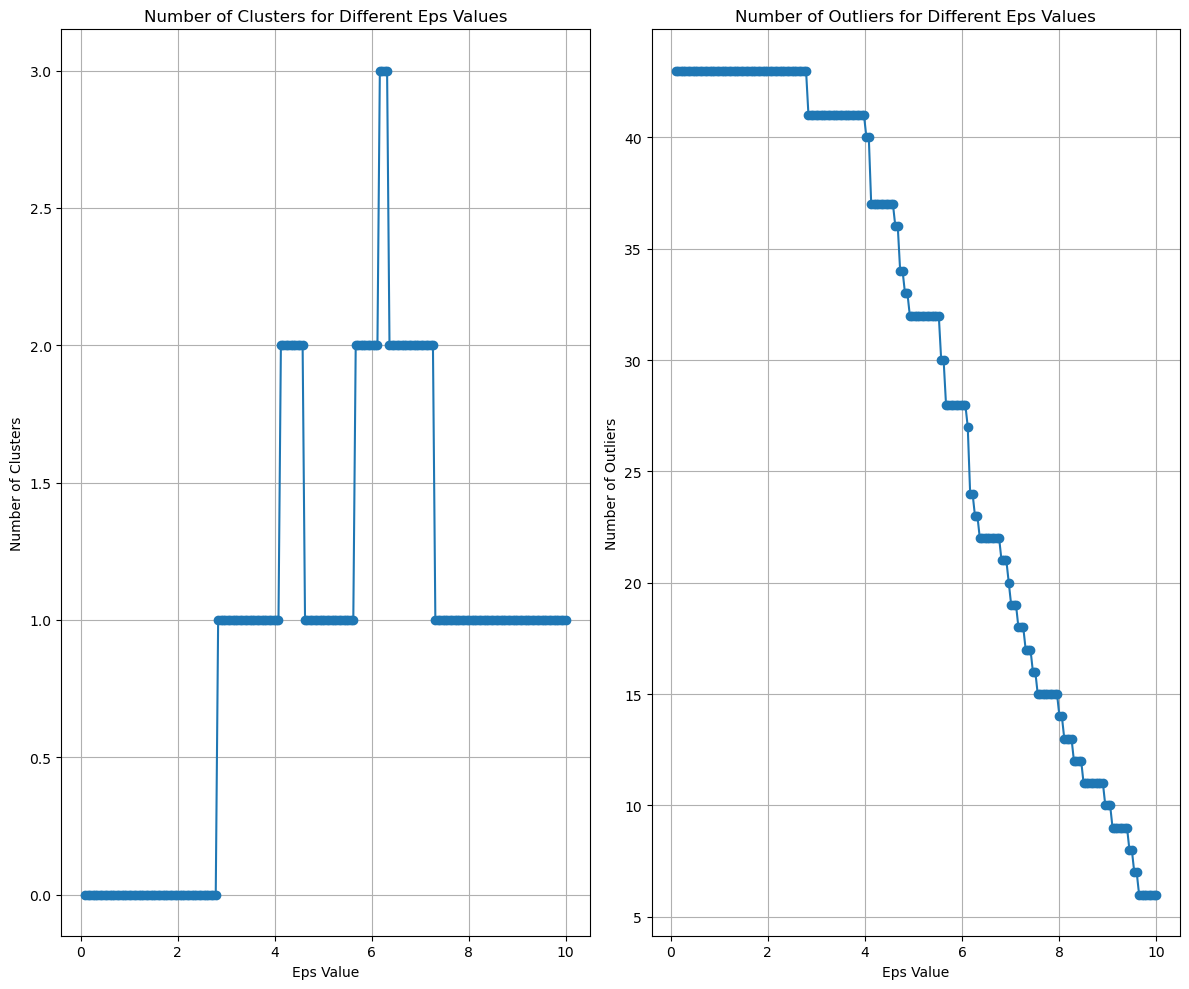

In [614]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, frontend_anomalies, 2)

In [615]:
dbscan = DBSCAN(eps=6.2, min_samples=2)
dbscan.fit(frontend_anomalies)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 3


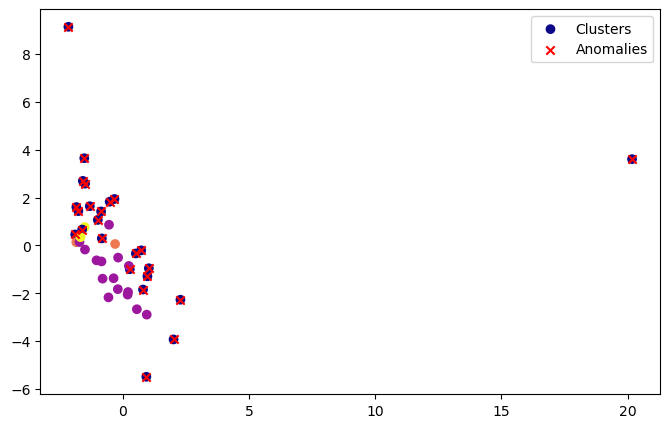

In [616]:
draw_clusters(frontend_anomalies, cluster_labels, is_anomaly)

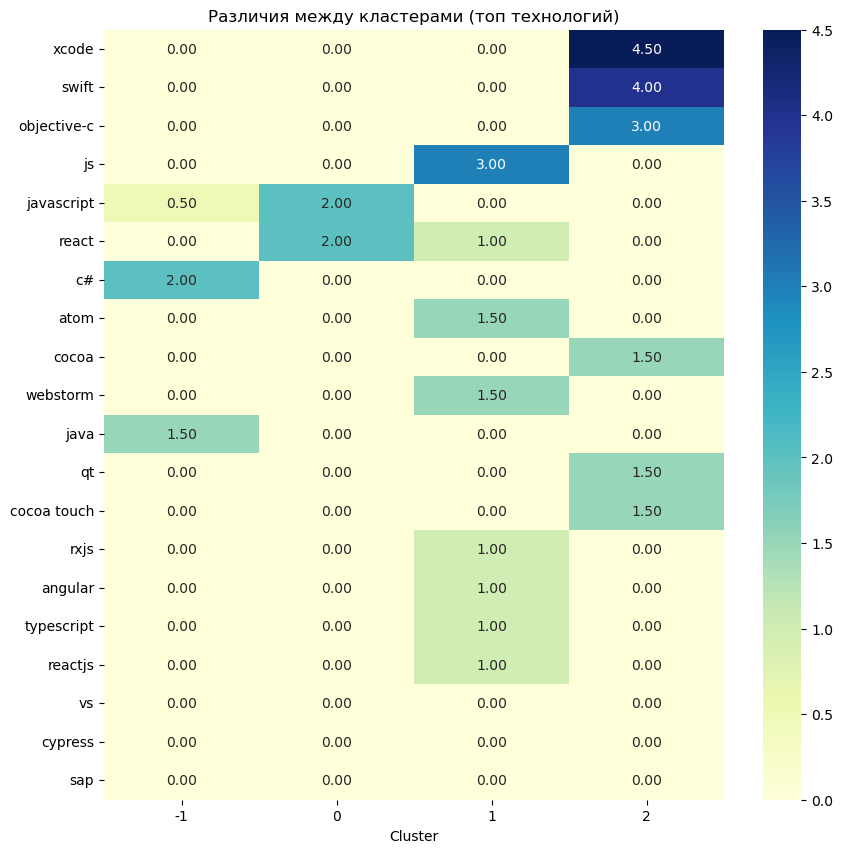

In [617]:
draw_heat_map(frontend_anomalies, frontend_anomalies.columns, cluster_labels, 20)

In [618]:
count_points_in_clusters(cluster_labels)

Кластер 0: 15 точек
Кластер 1: 2 точек
Кластер 2: 2 точек
Кластер -1: 24 точек


Вывод по фронтенду: характерные технологии JS, React, Java, VueJS, TypeScript

# UI/UX 

In [619]:
ui_ux_df = result_df[result_df['roles'].str.contains('ux/ui')]

ui_ux_df.head()

,"Единая учетная запись СПбГУ (например, ST000000)","Языки программирования (например: C++, Python, Java, etc)","Библиотеки и фреймворки для различных направлений использования (например: Qt, Numpy, Weka, Angular, PyTorch, etc)","Инструменты для проектирования, бизнес и системного анализа (например: BPMN, UML, Archimate, ARIS etc)","Инструменты для разработки ПО - например: VS Code, PyCharm, Git, etc)","Инструменты для тестирования (например: GTests, Selenium, Gatling, pytest etc)","Инструменты CI / CD (например: Jenkins, Travis CI, Docker, etc)","Инструменты для управления проектами (например: Jira, Trello, MS Project, etc)","Выберете интересующие Вас роли, в IT [Бизнес и системный анализ]","Выберете интересующие Вас роли, в IT [Дизайн UX / UI и проектирование интерфейсов]",...,yii,spacy,use case,travis cl,robot framework,directx,opevcv,phpmyadmin,assembler,yandex tank
12,ST110277,2,1,1,2,1,1,1,5,5,...,0,0,0,0,0,0,0,0,0,0
13,ST089430,C++ - 2\nPython - 2\nJava - 1,Numpy - 2,,VS Code - 2\nPyCharm - 2\nGit - 1,,,,3,5,...,0,0,0,0,0,0,0,0,0,0
34,ST086871,C++ 2\nPython 3\nC# 2,nan,nan,VS Code 1\nVS Community 2\nPyCharm 2\nGit 1,nan,nan,nan,3,5,...,0,0,0,0,0,0,0,0,0,0
38,ST095277,С++ - 2\nС# - 4\nPython - 1\nJava - 1\nHaskell...,.NET - 2,nan,GitHub - 3\nVisualStudio - 3,nan,nan,nan,1,5,...,0,0,0,0,0,0,0,0,0,0
45,ST097831,Python - 3\nR - 2\nJavaScript - 2\nС# - 1,Numpy - 3\nPandas - 3,nan,VS Code - 3\nGit - 3,pytest - 3,Docker - 2,Trello - 5\nJira - 2,3,5,...,0,0,0,0,0,0,0,0,0,0


In [620]:
ui_ux_df = ui_ux_df.drop(tech_columns, axis=1)
ui_ux_df = ui_ux_df.drop(['Единая учетная запись СПбГУ (например, ST000000)'], axis=1)
ui_ux_df = ui_ux_df.drop(role_columns, axis=1)
# ui_ux_df = ui_ux_df.drop(['python', 'c++', 'git', 'numpy', 'pycharm'], axis=1)
ui_ux_df = ui_ux_df.drop(['python', 'c++', 'git', 'pycharm', 'numpy', 'vscode', 'visual studio', 'vs code', 'trello', 'jira', 'docker', 'pandas', 'slack', 'notion'], axis=1) 

In [621]:
# Проверяем, какие колонки полностью состоят из нулевых значений
zero_columns = ui_ux_df.columns[ui_ux_df.eq(0).all(axis=0)]

print("Колонки с нулевыми значениями:", zero_columns.tolist())

ui_ux_df = ui_ux_df.drop(zero_columns, axis=1)

data_ui_ux = ui_ux_df.values

Колонки с нулевыми значениями: ['capybara', 'ember', 'j', 'streamlit', 'greenplum', 'tortoise', 'spring mvc', 'jupyter-notebook', 'nemo', 'jupyter notebook', 'evernote', 'springsecurity', 'retrofit', 'fragments', 'decker', 'make', 'fltk', 'gradle', 'folium', 'xgboost', 'quill', 'phpstorm', 'azure', 'tokio-rs', 'android sdk', 'intellj idea', 'blazor', 'gdal', 'tableau', 'anaconda jupyter notebook', 'jquery', 'addressables', 'kibana', 'gensim', 'microsoft azure', 'pascal', 'vulkan', 'wandb', 'clap-rs', 'springweb', 'prophet', 'jetbrains', 'linq', 'implicit', 'scikit-learn', 'wsgiref', 'jupiter notebook', 'gitlab-ci', 'golang', 'github actions', 'gdi+', 'cocoa', 'vmwareworkstation', 'ef core', 'symphony', 'pytest-xdist', 'pyspark', 'surprise', 'nunit', 'gtests', 'coroutines', 'jupyter lab', 'next', 'googlecolab', 'reactivex', 'gohit', 'rayon', 'pyav', 'razor pages', 'nest js', 'java script', 'arduino', 'typing', 'wakatime', 'hascell', 'material design', 'net', 'aiogram', 'vim', 'sentry', 

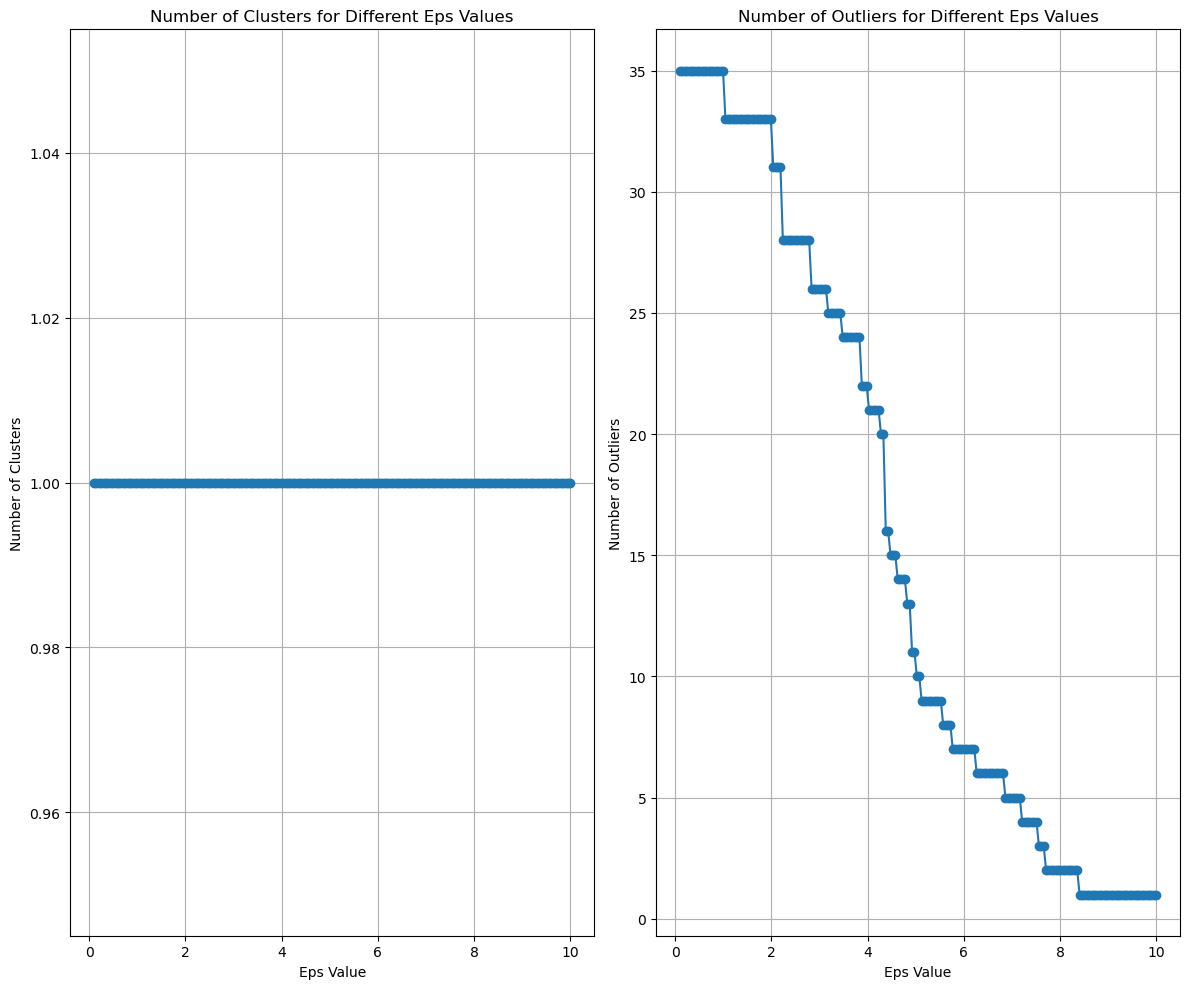

In [622]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, data_ui_ux)

In [623]:
dbscan = DBSCAN(eps=3.965, min_samples=5)
dbscan.fit(data_ui_ux)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 1


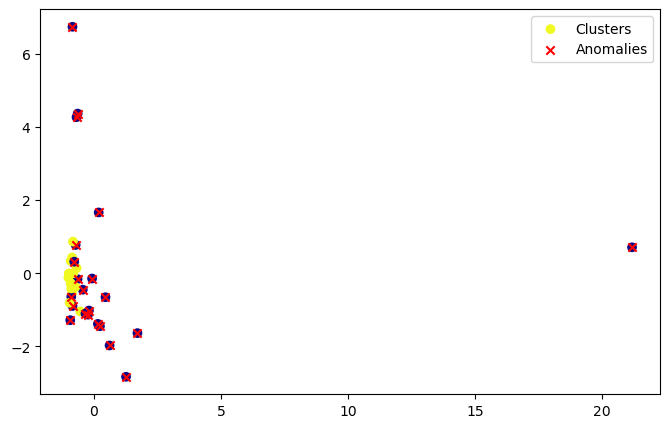

In [624]:
draw_clusters(data_ui_ux, cluster_labels, is_anomaly)

In [625]:
count_points_in_clusters(cluster_labels)

Кластер 0: 20 точек
Кластер -1: 22 точек


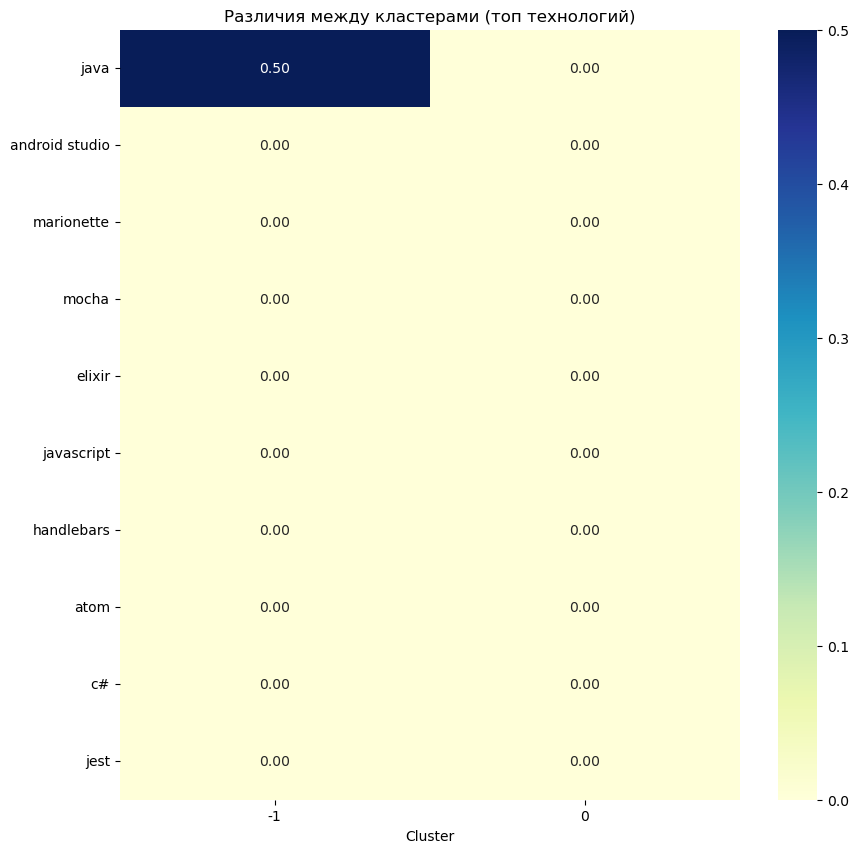

In [626]:
draw_heat_map(data_ui_ux, ui_ux_df.columns, cluster_labels)  # сделать перегрузку функций?

### UI/UX anomalies

In [627]:
ui_ux_anomalies = ui_ux_df[is_anomaly]
ui_ux_anomalies.head()

,android studio,reactjs,gitlab ci,uikit,lua,ruby on rails,ts,ruby,stryker,matlab,...,notepad++,seaborn,js,wpf,kotlin,tensorflow,intellij idea,teamcity,rust,phpmyadmin
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0


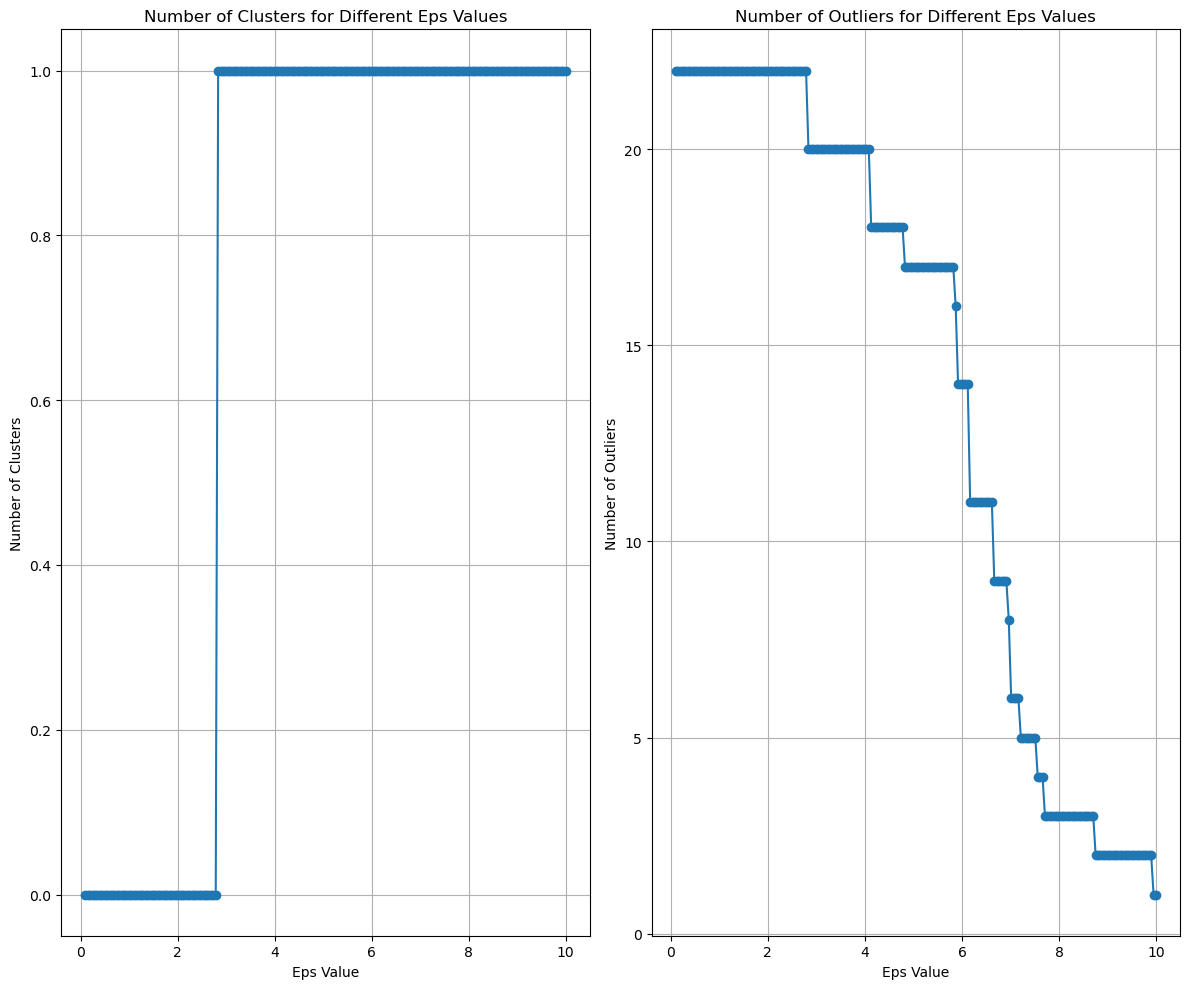

In [628]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, ui_ux_anomalies, 2)

In [629]:
# 4.9 - 6 clusters
# 5.5 - 4 clusters 3

In [630]:
dbscan = DBSCAN(eps=6.1, min_samples=2)
dbscan.fit(ui_ux_anomalies)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 1


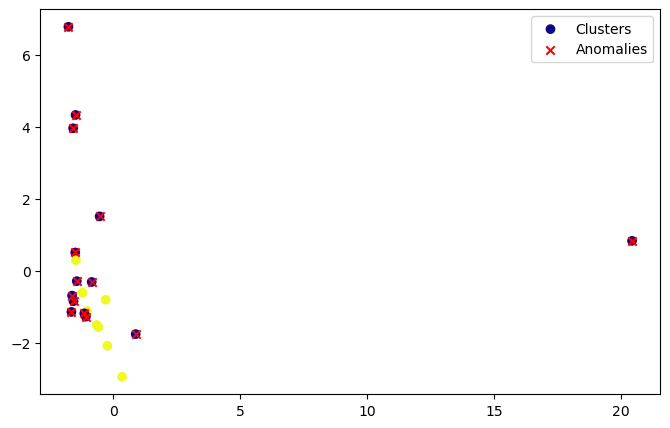

In [631]:
draw_clusters(ui_ux_anomalies, cluster_labels, is_anomaly)

In [632]:
count_points_in_clusters(cluster_labels)

Кластер 0: 8 точек
Кластер -1: 14 точек


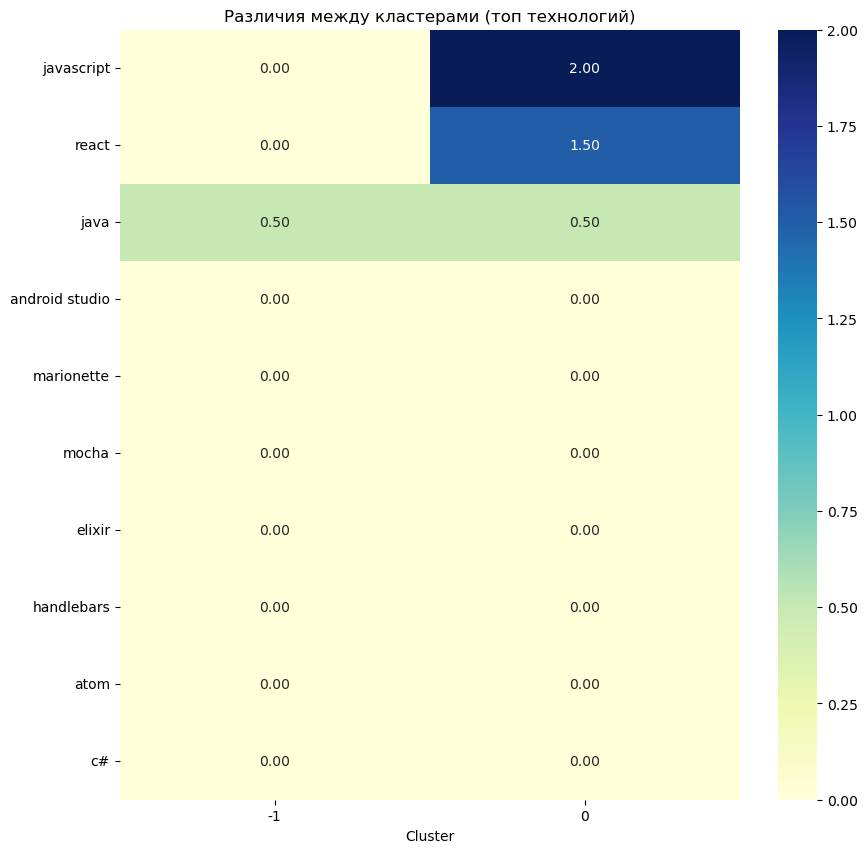

In [633]:
draw_heat_map(ui_ux_anomalies, ui_ux_anomalies.columns, cluster_labels, 10)

Вывод по UI/UX:

# PM

In [718]:
pm_df = result_df[result_df['roles'].str.contains('pm')]
pm_df = pm_df[pm_techs]
pm_df.head()

,microsoft todo,azure devops server,yandextracker,ms project,miro,mindmeister,youtrack,slack,jetbrains teamcity,azure devops,...,unity,gitlab,jira,basecamp,todoist,github projects,notion,bitbucket,clickup,evernote
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [676]:
# pm_df = pm_df.drop(tech_columns, axis=1) 
# pm_df = pm_df.drop(['Единая учетная запись СПбГУ (например, ST000000)'], axis=1)
# pm_df = pm_df.drop(role_columns, axis=1)

# sa_ba_df = sa_ba_df.drop(['python', 'c++', 'git', 'pycharm', 'numpy', 'vscode', 'visual studio', 'vs code', 'docker', 'pandas'], axis=1) 

In [719]:
# Проверяем, какие колонки полностью состоят из нулевых значений
zero_columns = pm_df.columns[pm_df.eq(0).all(axis=0)]

print("Колонки с нулевыми значениями:", zero_columns.tolist())

pm_df = pm_df.drop(zero_columns, axis=1)

data_pm = pm_df.values

Колонки с нулевыми значениями: ['microsoft todo', 'azure devops server', 'yandextracker', 'youtrack', 'slack', 'jetbrains teamcity', 'azure devops', 'telegram', 'ms teams', 'pivotaltracker', 'unity', 'evernote']


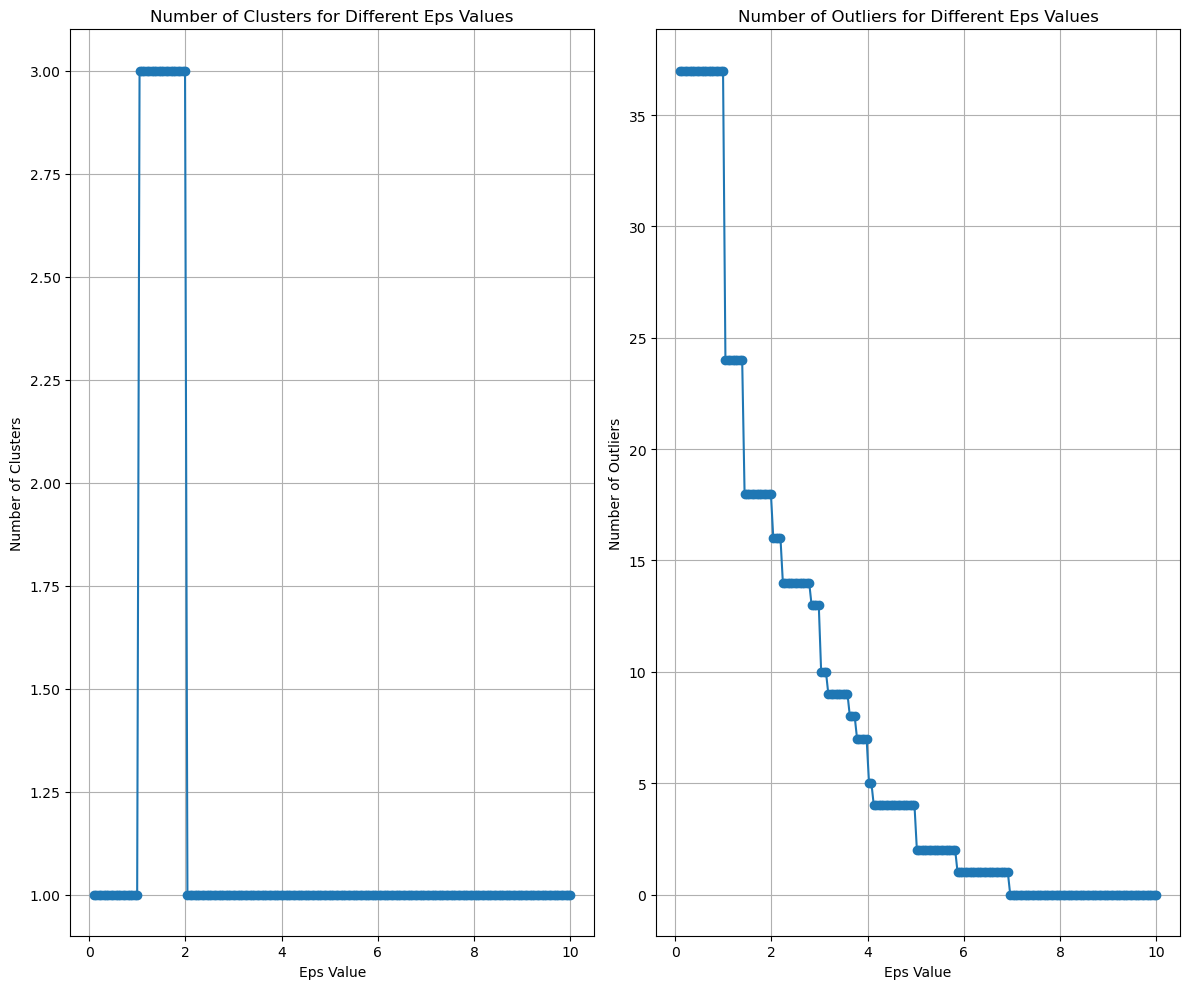

In [720]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, data_pm)

In [722]:
dbscan = DBSCAN(eps=1.9, min_samples=5)
dbscan.fit(data_pm)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 3


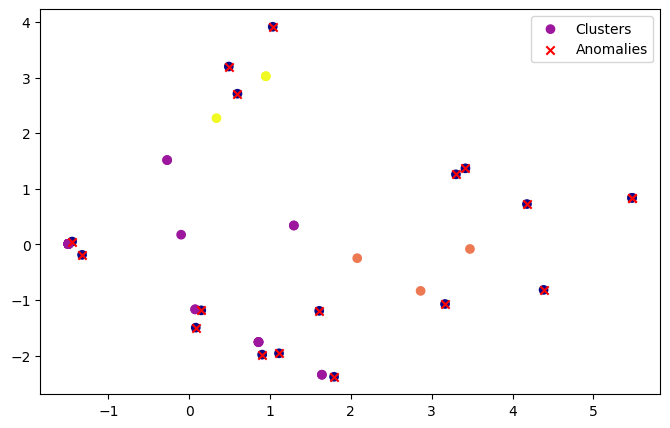

In [723]:
draw_clusters(data_pm, cluster_labels, is_anomaly)

In [724]:
count_points_in_clusters(cluster_labels)

Кластер 0: 49 точек
Кластер 1: 3 точек
Кластер 2: 3 точек
Кластер -1: 18 точек


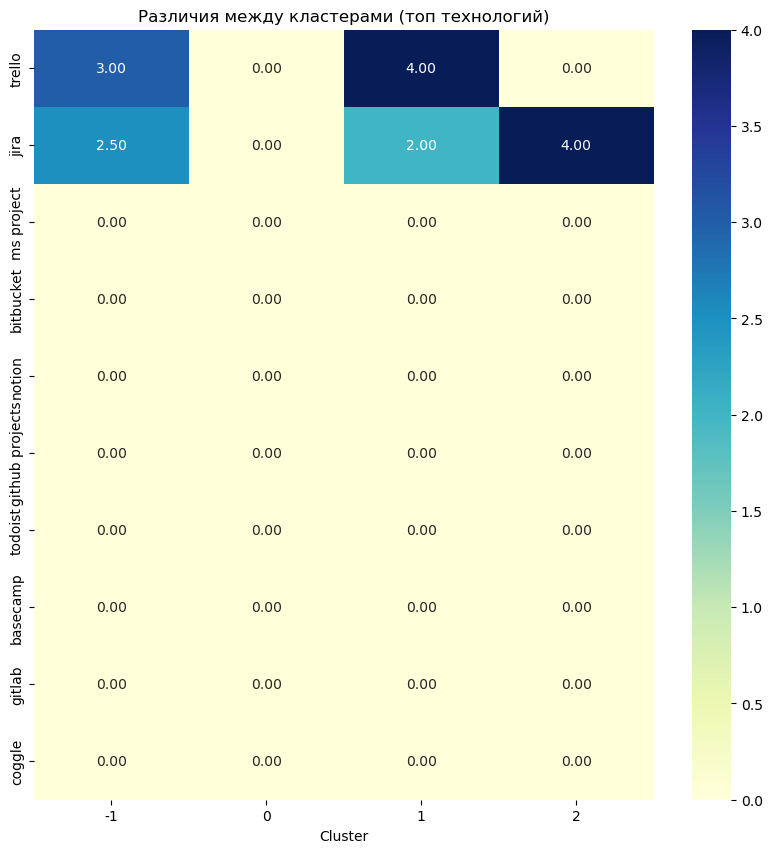

In [725]:
draw_heat_map(data_pm, pm_df.columns, cluster_labels) 

## PM anomalies

In [726]:
pm_anomalies = pm_df[is_anomaly]
pm_anomalies.head()

,ms project,miro,mindmeister,monday.com,gitlab projects,confluence,zoom,asana,github,coggle,trello,gitlab,jira,basecamp,todoist,github projects,notion,bitbucket,clickup
46,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,4,0,0
62,0,0,0,0,0,0,0,0,0,0,3,2,1,0,0,0,0,3,0
70,0,3,0,0,0,0,3,0,0,0,0,0,3,0,0,0,4,0,0
79,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0
114,0,3,0,0,0,3,0,0,0,0,0,0,3,0,0,0,0,0,0


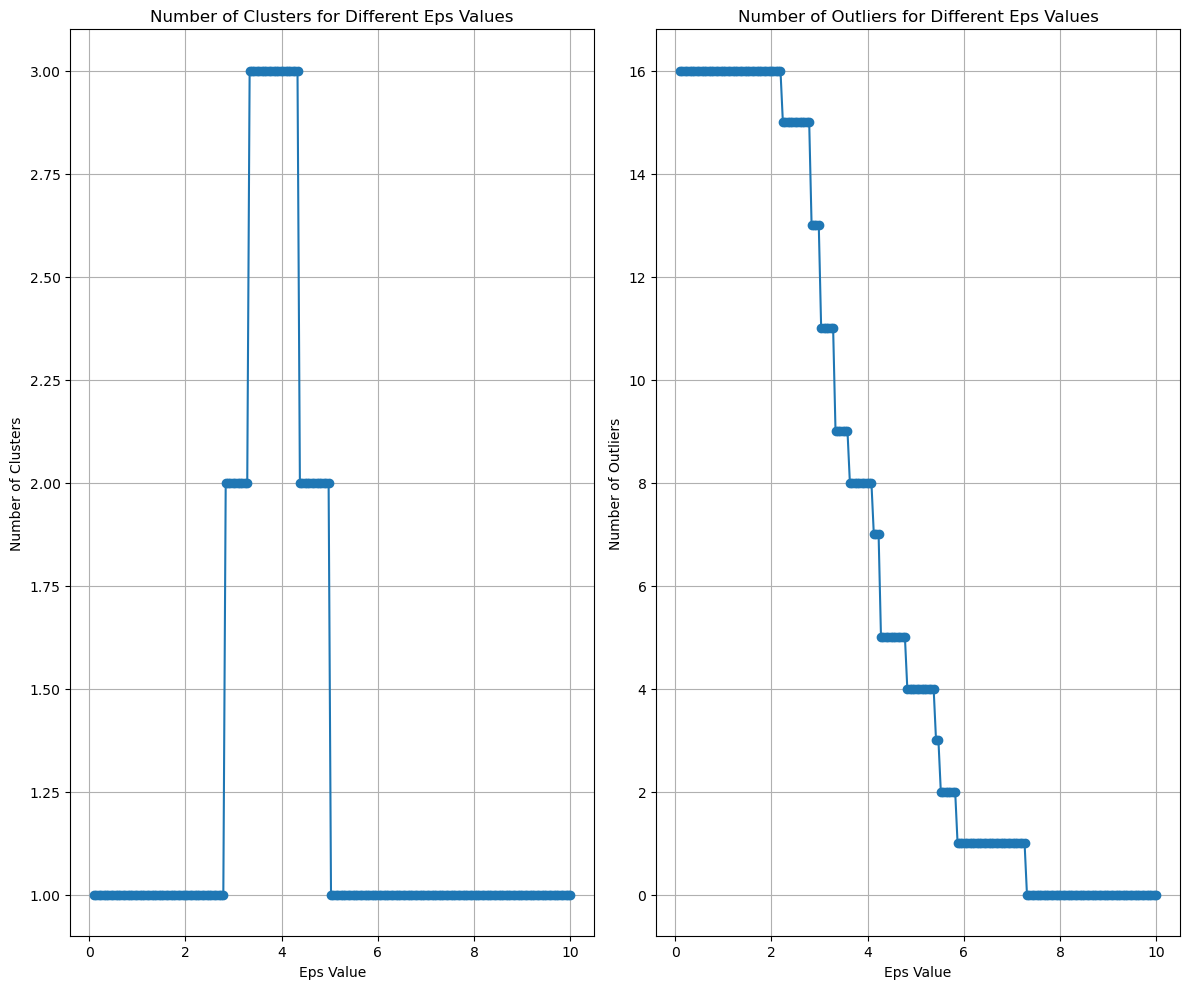

In [727]:
find_parameters_for_DBSCUN(0.1, 10.0, 200,  pm_anomalies, 2)

In [728]:
dbscan = DBSCAN(eps=4.2, min_samples=2)
dbscan.fit(pm_anomalies)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 3


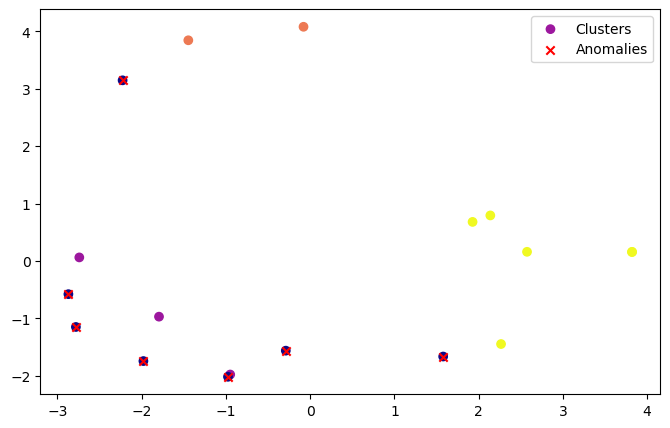

In [729]:
draw_clusters(pm_anomalies, cluster_labels, is_anomaly)

In [730]:
count_points_in_clusters(cluster_labels)

Кластер 0: 3 точек
Кластер 1: 2 точек
Кластер 2: 6 точек
Кластер -1: 7 точек


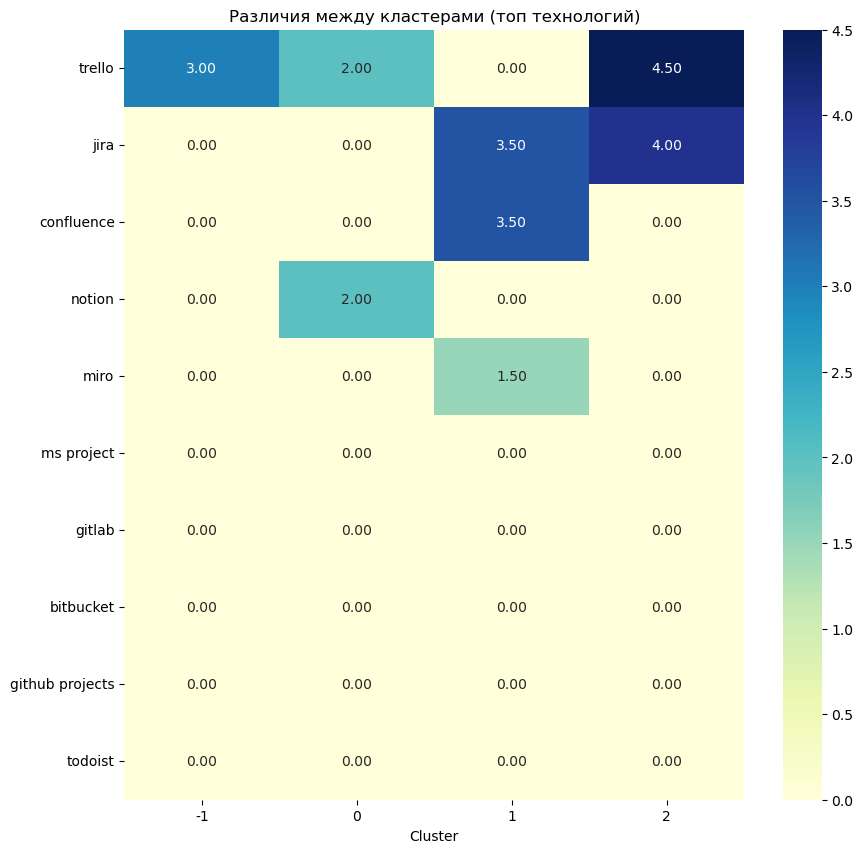

In [731]:
draw_heat_map(pm_anomalies, pm_anomalies.columns, cluster_labels)

Вывод: популярны trello, jira, confluence, notion, miro

# Implementation

In [732]:
imp_df = result_df[result_df['roles'].str.contains('implementation')]
imp_df = imp_df[imp_techs]
imp_df.head()


,cd,decker,iis manager,cl,docker-compose,gitactions,docker,aws cloudformation,gitlab-ci,maven,...,gitlab,microsoft azure,podman,openshift,github actions,kubernetes,s,cicleci,travis cl,teamcity
5,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [690]:
# imp_df = imp_df.drop(tech_columns, axis=1) 
# imp_df = imp_df.drop(['Единая учетная запись СПбГУ (например, ST000000)'], axis=1)
# imp_df = imp_df.drop(role_columns, axis=1)

In [733]:
imp_df = drop_zero_columns(imp_df)
data_imp = imp_df.values

Колонки с нулевыми значениями: ['decker', 'iis manager', 'cl', 'docker-compose', 'gitactions', 'gitlab-ci', 'maven', 'gradle', 'travis', 'gitlab ci', 'gitlab', 'microsoft azure', 'podman', 'openshift', 's', 'cicleci', 'travis cl', 'teamcity']


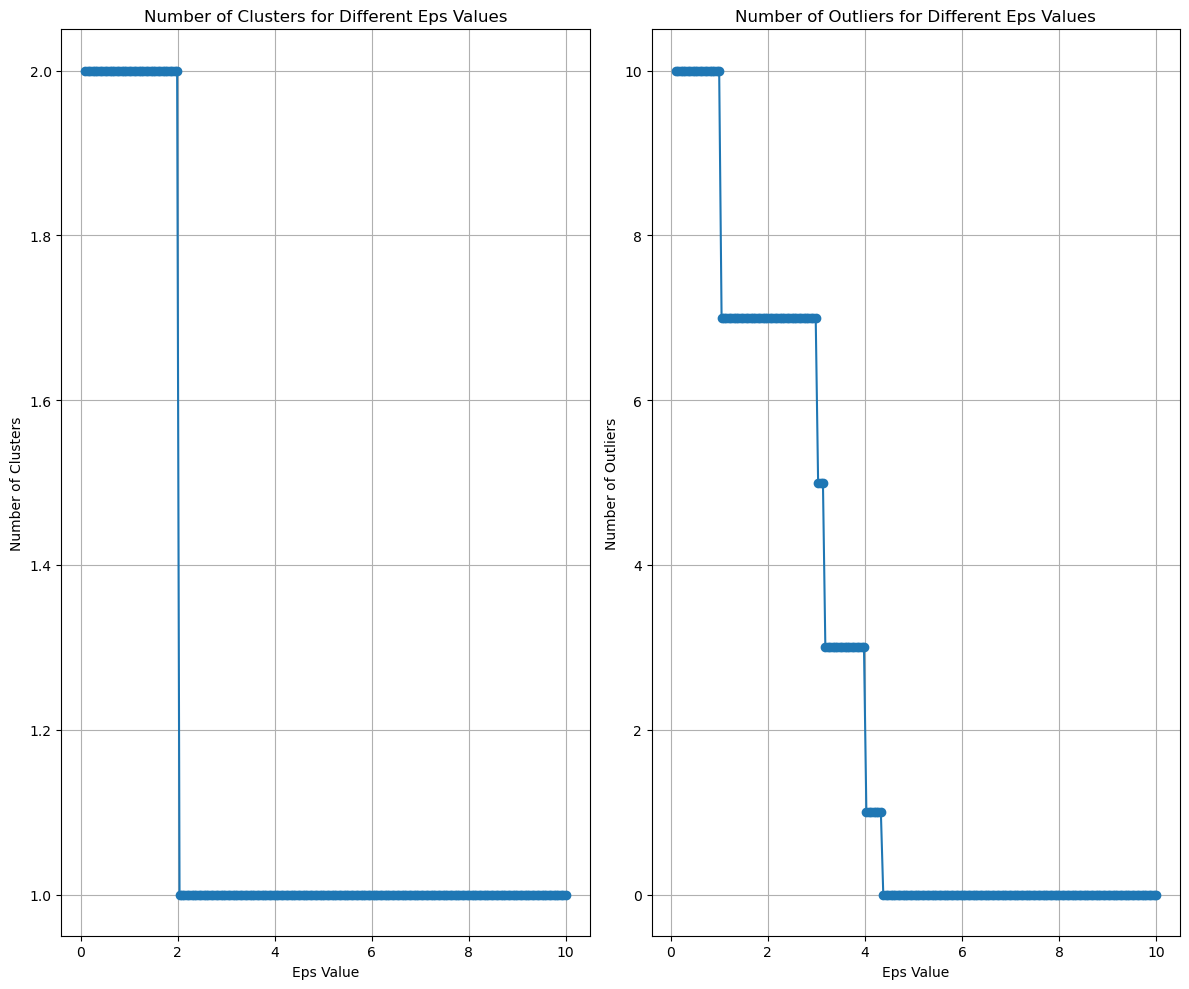

In [734]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, data_imp)

In [735]:
dbscan = DBSCAN(eps=1.9, min_samples=5)
dbscan.fit(data_imp)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 2


In [736]:
count_points_in_clusters(cluster_labels)

Кластер 0: 9 точек
Кластер 1: 11 точек
Кластер -1: 7 точек


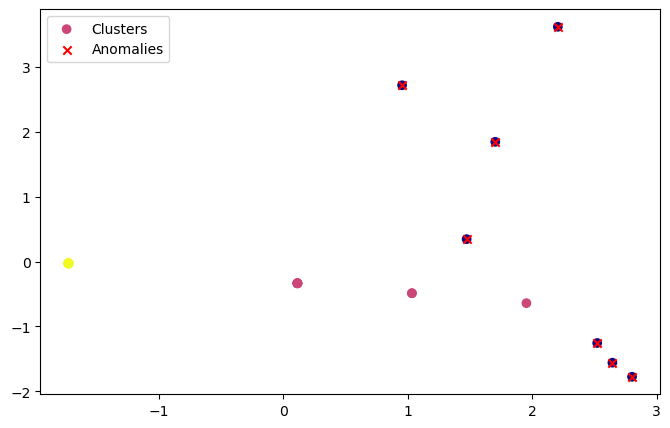

In [737]:
draw_clusters(data_imp, cluster_labels, is_anomaly)

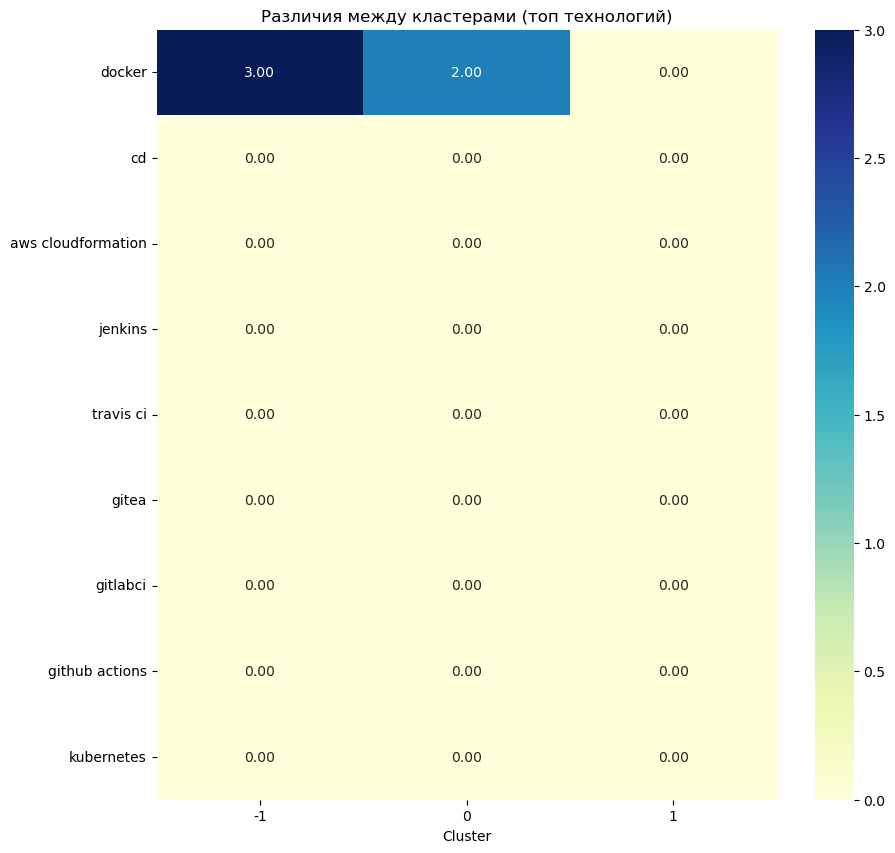

In [738]:
draw_heat_map(data_imp, imp_df.columns, cluster_labels) 

## Implementation anomalies

In [743]:
imp_anomalies = imp_df[is_anomaly]
imp_anomalies.head()

ValueError: Item wrong length 7 instead of 27.

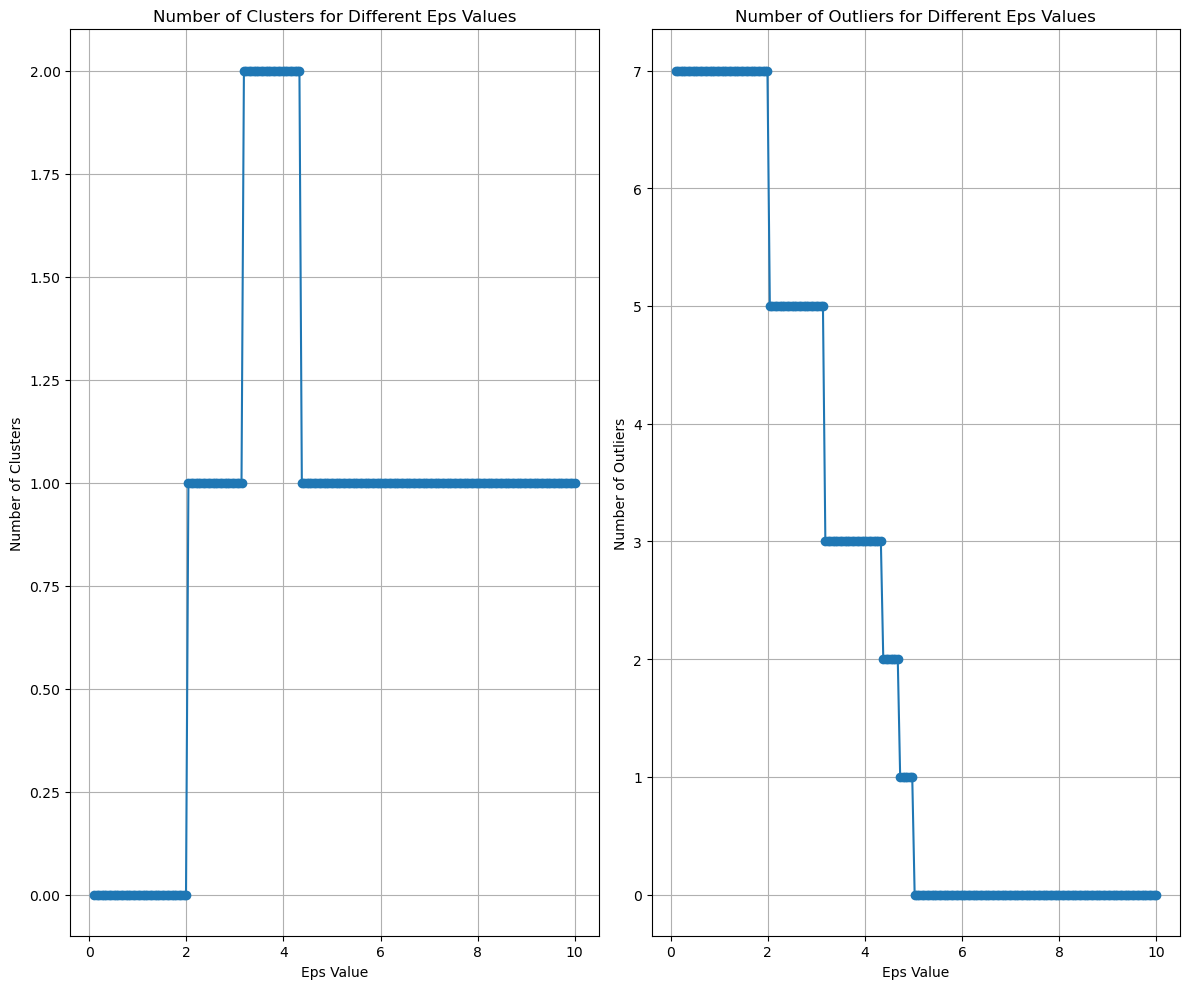

In [744]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, imp_anomalies, 2)

In [746]:
dbscan = DBSCAN(eps=4.1, min_samples=2)
dbscan.fit(imp_anomalies)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 2


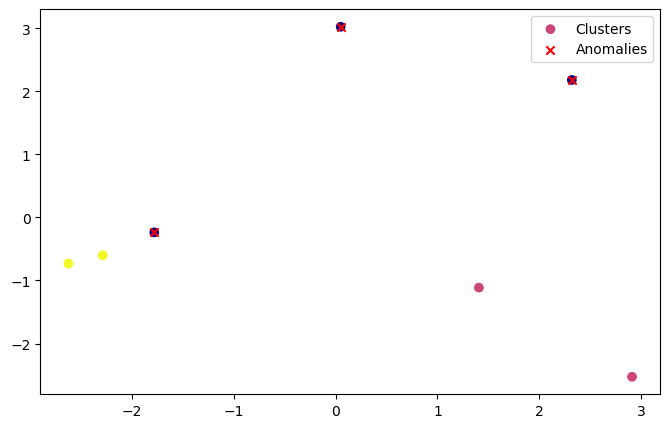

Кластер 0: 2 точек
Кластер 1: 2 точек
Кластер -1: 3 точек


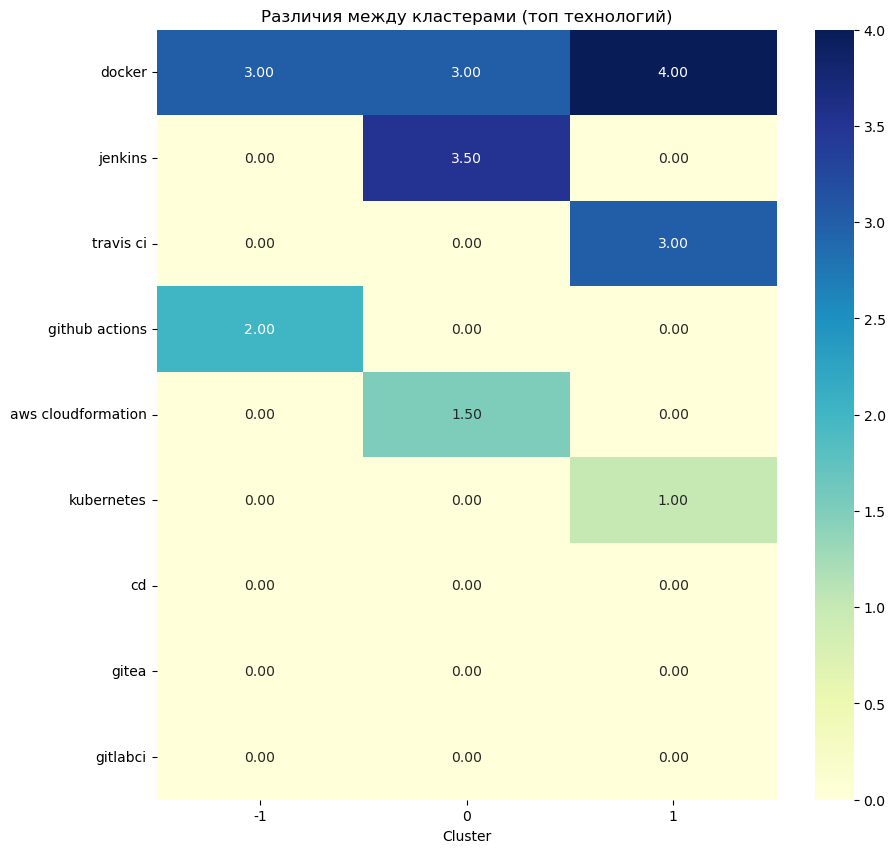

In [747]:
draw_clusters(imp_anomalies, cluster_labels, is_anomaly)
count_points_in_clusters(cluster_labels)
draw_heat_map(imp_anomalies, imp_anomalies.columns, cluster_labels, 20)

**Выводы по внедрению и развертыванию**: docker, github actions, jenkins, travis ci 

# System or business analyst

In [748]:
sa_ba_df = result_df[result_df['roles'].str.contains('system or business analyst')]
sa_ba_df.head()

,"Единая учетная запись СПбГУ (например, ST000000)","Языки программирования (например: C++, Python, Java, etc)","Библиотеки и фреймворки для различных направлений использования (например: Qt, Numpy, Weka, Angular, PyTorch, etc)","Инструменты для проектирования, бизнес и системного анализа (например: BPMN, UML, Archimate, ARIS etc)","Инструменты для разработки ПО - например: VS Code, PyCharm, Git, etc)","Инструменты для тестирования (например: GTests, Selenium, Gatling, pytest etc)","Инструменты CI / CD (например: Jenkins, Travis CI, Docker, etc)","Инструменты для управления проектами (например: Jira, Trello, MS Project, etc)","Выберете интересующие Вас роли, в IT [Бизнес и системный анализ]","Выберете интересующие Вас роли, в IT [Дизайн UX / UI и проектирование интерфейсов]",...,yii,spacy,use case,travis cl,robot framework,directx,opevcv,phpmyadmin,assembler,yandex tank
11,ST112784,Python - 1,nan,nan,nan,nan,nan,nan,5,1,...,0,0,0,0,0,0,0,0,0,0
12,ST110277,2,1,1,2,1,1,1,5,5,...,0,0,0,0,0,0,0,0,0,0
24,ST068916,"c++, phython - 2","Numpy, Pandas - 2","BPMN, UML, power BI - 2","VS Code, PyCharm, Git - 2",,,"Jira, Trello - 3",5,1,...,0,0,0,0,0,0,0,0,0,0
32,ST115983,C++ - 4\nC# - 3\nAHK - 3\nJavaScript - 3\nJav...,React - 2\nVue - 3\nYii - 3\nLaravel - 3\nQt -...,UML - 3\nUML - 3,VS Code - 3\nPyCharm - 5\nGit - 4\nVS - 3\nVS ...,pytest - 3\nunittest - 3\nmutmut - 3\npytest -...,Jenkins - 2\nDocker - 3\nGitlab CI/CD - 2\nGit...,Jira - 1\nTrello - 1\n,5,3,...,3,0,0,0,0,0,0,0,0,0
36,ST095276,С++ - 2\nJava - 2\nPython - 3\nSQL - 2\n,Numpy - 3\nPandas - 4\nMatplotlib - 3\nSeaborn...,nan,VS Code - 4\nGit - 3,GTests - 2\n,Docker - 1\n,nan,5,3,...,0,0,0,0,0,0,0,0,0,0


In [703]:
# sa_ba_df = sa_ba_df.drop(tech_columns, axis=1) 
# sa_ba_df = sa_ba_df.drop(['Единая учетная запись СПбГУ (например, ST000000)'], axis=1)
# sa_ba_df = sa_ba_df.drop(role_columns, axis=1)
# sa_ba_df = sa_ba_df.drop(['python', 'c++', 'git', 'pycharm', 'numpy', 'vscode', 'visual studio', 'vs code', 'docker', 'pandas'], axis=1) 

In [749]:
sa_ba_df = sa_ba_df[sa_ba_techs]

In [750]:
# # Проверяем, какие колонки полностью состоят из нулевых значений
# zero_columns = sa_ba_df.columns[sa_ba_df.eq(0).all(axis=0)]

# print("Колонки с нулевыми значениями:", zero_columns.tolist())

# sa_ba_df = sa_ba_df.drop(zero_columns, axis=1)
sa_ba_df = drop_zero_columns(sa_ba_df)

data_sa_ba = sa_ba_df.values

Колонки с нулевыми значениями: ['er', 'aris', 'use case', 'archimate', 'excel', 'lucidchart', 'sap', 'sentry', 'draw.io', 'user story']


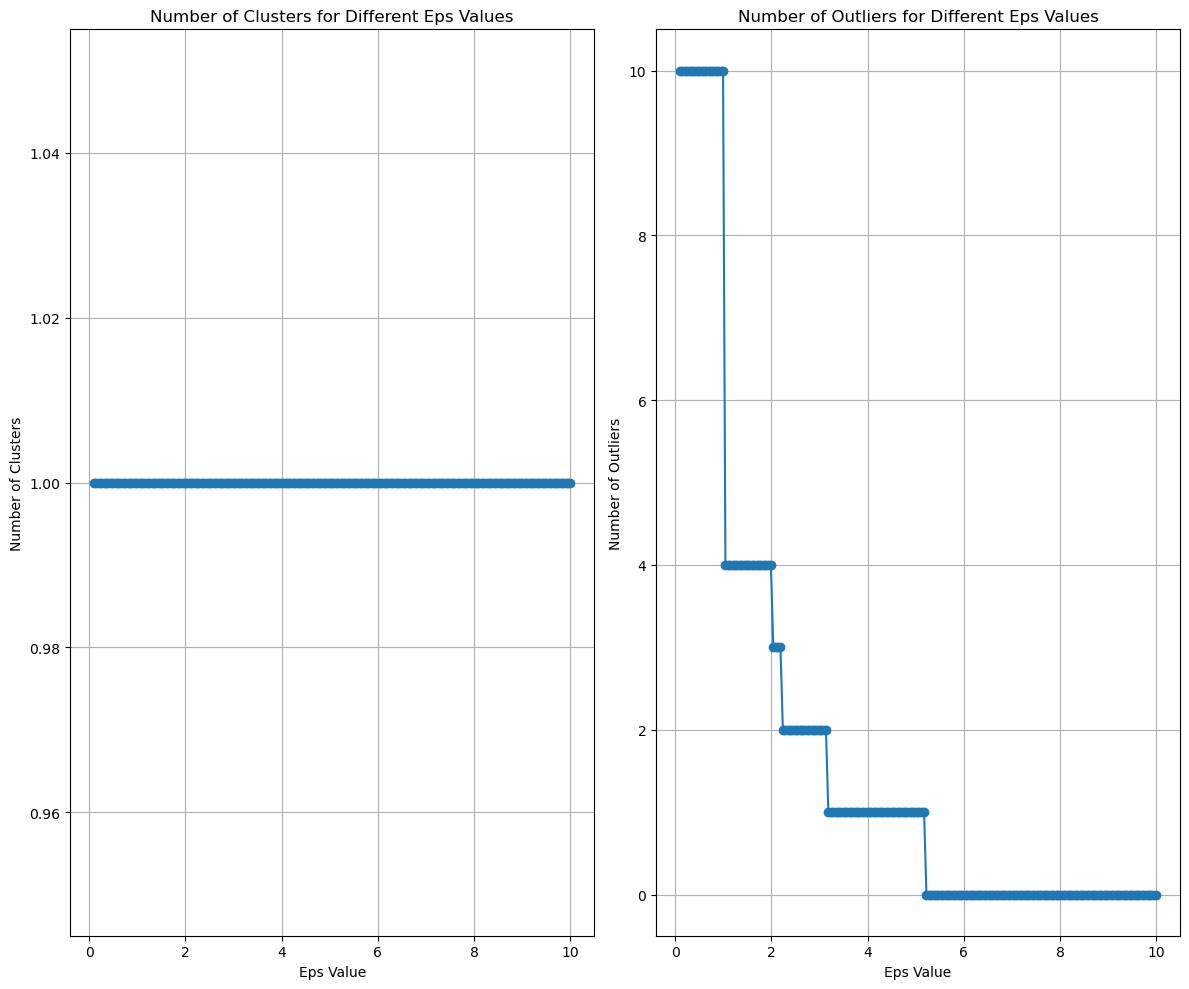

In [751]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, data_sa_ba)

In [754]:
dbscan = DBSCAN(eps=0.1, min_samples=5)
dbscan.fit(data_sa_ba)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 1


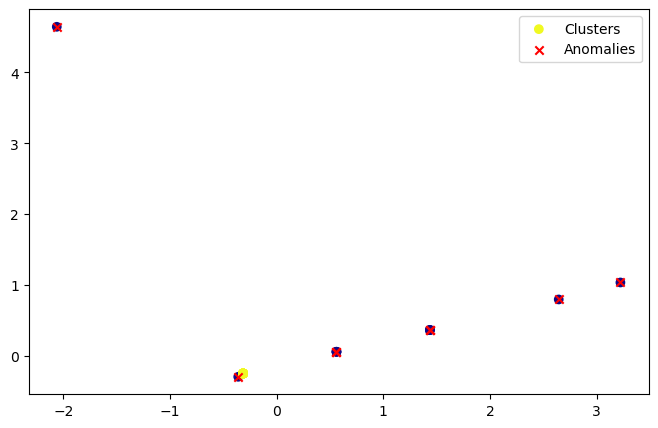

In [755]:
draw_clusters(data_sa_ba, cluster_labels, is_anomaly)

In [756]:
count_points_in_clusters(cluster_labels)

Кластер 0: 30 точек
Кластер -1: 10 точек


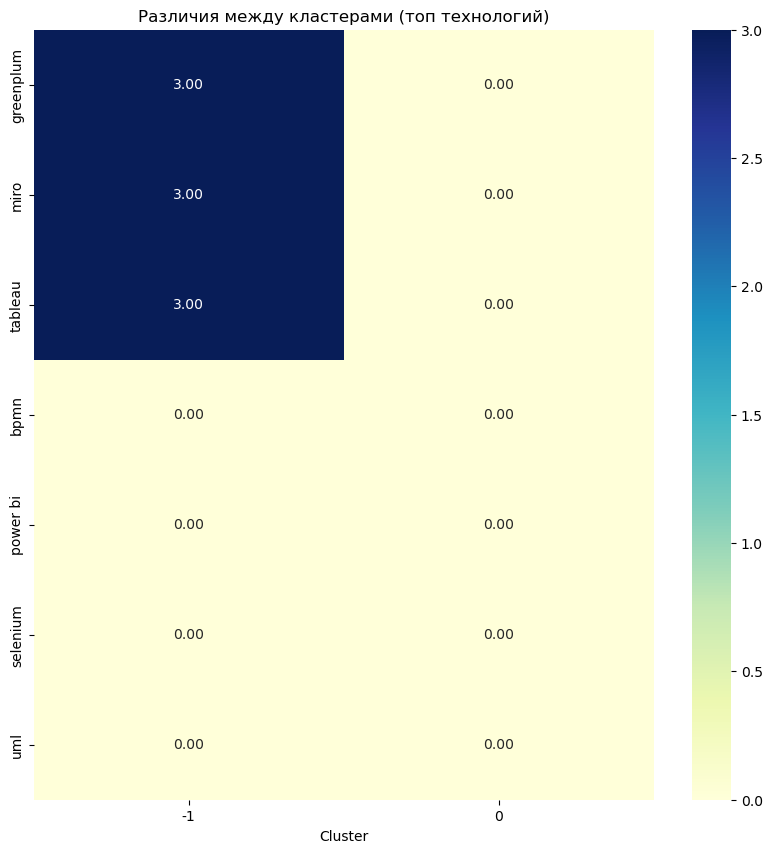

In [710]:
draw_heat_map(data_sa_ba, sa_ba_df.columns, cluster_labels) 

## SA BA Anomalies

In [757]:
sa_ba_anomalies = sa_ba_df[is_anomaly]
sa_ba_anomalies.head()

,greenplum,bpmn,miro,power bi,selenium,tableau,uml
24,0,0,0,2,0,0,0
32,0,0,0,0,3,0,3
87,0,0,0,0,0,0,1
102,0,0,0,0,0,0,2
114,3,0,3,0,0,3,0


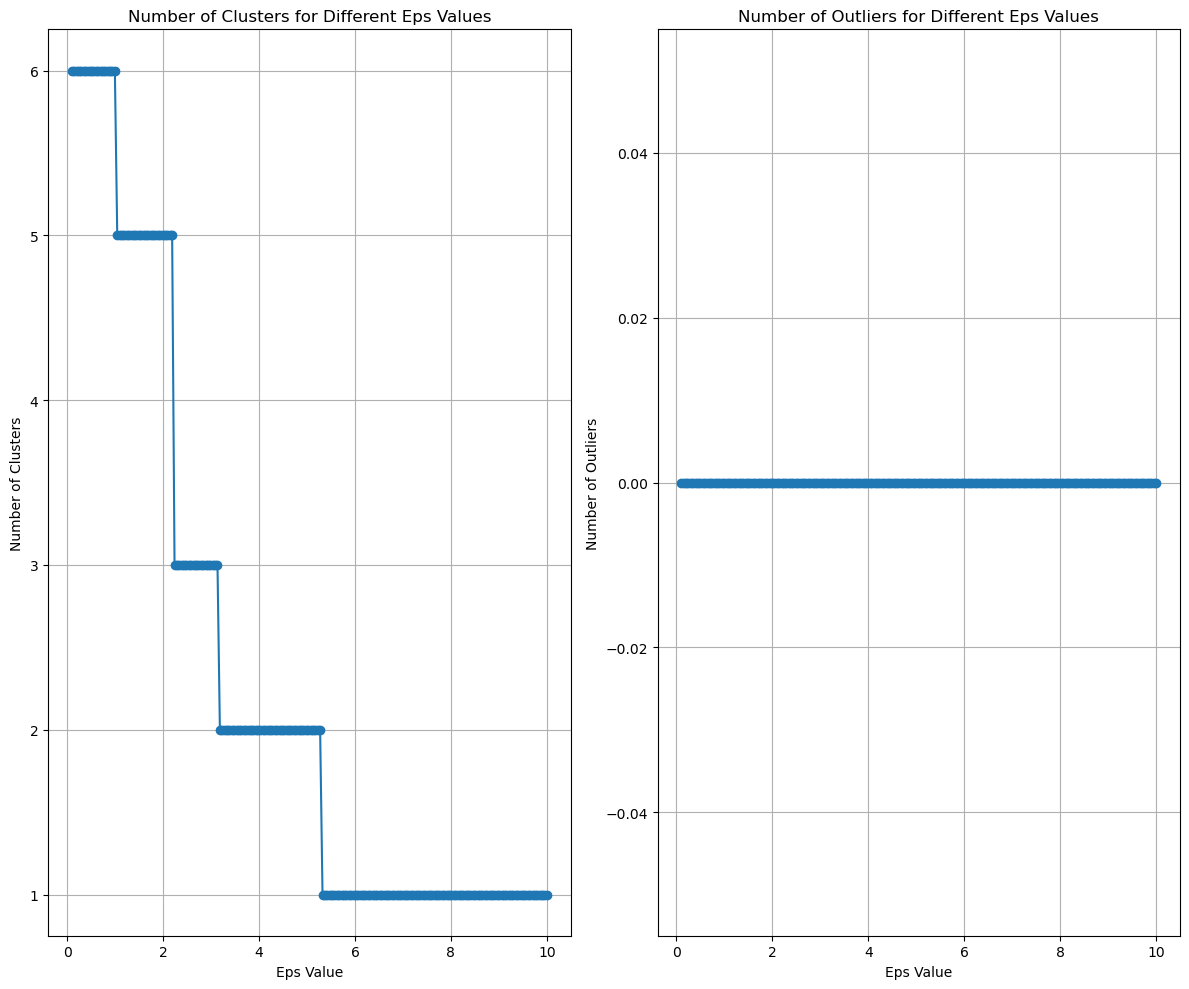

In [758]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, sa_ba_anomalies, 1)

In [762]:
dbscan = DBSCAN(eps=4, min_samples=1)
dbscan.fit(sa_ba_anomalies)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 2


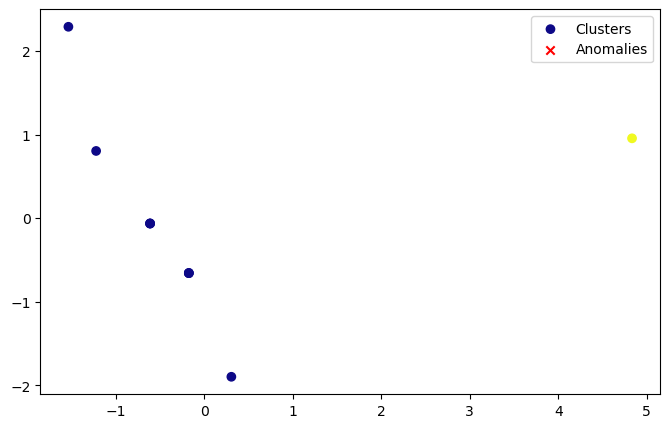

In [763]:
draw_clusters(sa_ba_anomalies, cluster_labels, is_anomaly)

In [764]:
count_points_in_clusters(cluster_labels)

Кластер 0: 9 точек
Кластер 1: 1 точек


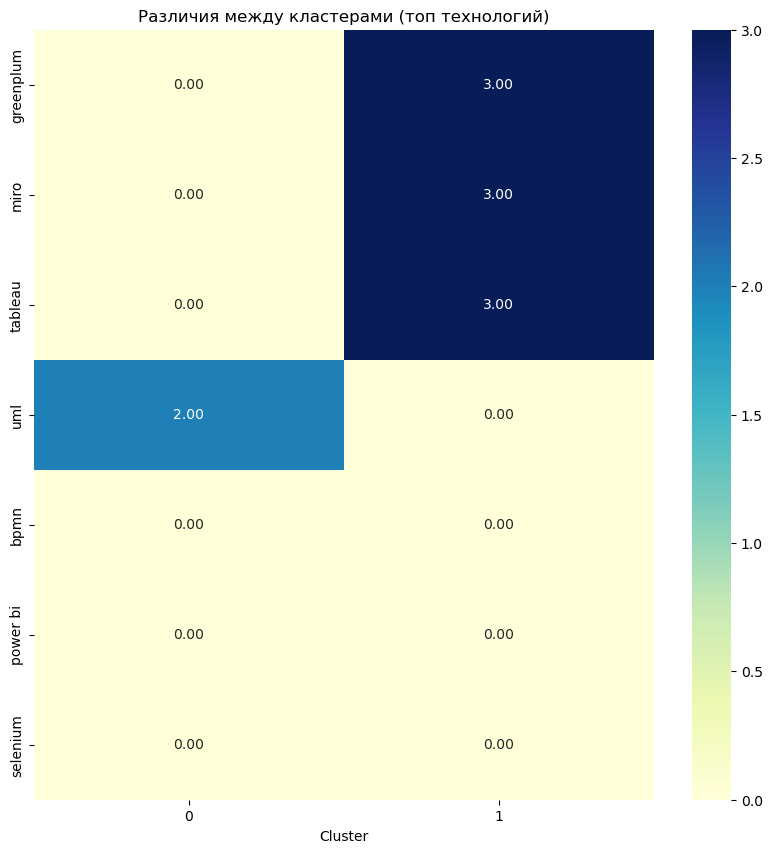

In [765]:
draw_heat_map(sa_ba_anomalies, sa_ba_anomalies.columns, cluster_labels, 25)

Выводы по BA/SA: нужно посмотреть данные с оценкой >= 4

**Выводы по BA/SA**: greenplum, miro, tableau, uml

# QA

In [786]:
qa_df = result_df[result_df['roles'].str.contains('qa')]
qa_df.head()

,"Единая учетная запись СПбГУ (например, ST000000)","Языки программирования (например: C++, Python, Java, etc)","Библиотеки и фреймворки для различных направлений использования (например: Qt, Numpy, Weka, Angular, PyTorch, etc)","Инструменты для проектирования, бизнес и системного анализа (например: BPMN, UML, Archimate, ARIS etc)","Инструменты для разработки ПО - например: VS Code, PyCharm, Git, etc)","Инструменты для тестирования (например: GTests, Selenium, Gatling, pytest etc)","Инструменты CI / CD (например: Jenkins, Travis CI, Docker, etc)","Инструменты для управления проектами (например: Jira, Trello, MS Project, etc)","Выберете интересующие Вас роли, в IT [Бизнес и системный анализ]","Выберете интересующие Вас роли, в IT [Дизайн UX / UI и проектирование интерфейсов]",...,yii,spacy,use case,travis cl,robot framework,directx,opevcv,phpmyadmin,assembler,yandex tank
29,ST105895,С++ - 4\nPython - 2,Vue - 1\nNumpy - 2\nPandas - 2\nAsio - 1,nan,VS code - 3\nVisual Studio - 4\nGit - 4,nan,nan,nan,3,1,...,0,0,0,0,0,0,0,0,0,0
45,ST097831,Python - 3\nR - 2\nJavaScript - 2\nС# - 1,Numpy - 3\nPandas - 3,nan,VS Code - 3\nGit - 3,pytest - 3,Docker - 2,Trello - 5\nJira - 2,3,5,...,0,0,0,0,0,0,0,0,0,0
60,ST110625,Python - 2,Numpy - 1,nan,nan,nan,nan,nan,5,1,...,0,0,0,0,0,0,0,0,0,0
63,ST115977,Python - 3\nC++ - 2,Numpy - 2\nPyTorch - 2\nFlask - 3,BPMN - 2,PyCharm - 3\nVisual Studio - 3,nan,Docker - 1,Jira - 1\nTrello - 1,1,1,...,0,0,0,0,0,0,0,0,0,0
89,ST087238,C++ - 2\nPython - 1\nJava - 1,nan,nan,nan,nan,nan,nan,1,1,...,0,0,0,0,0,0,0,0,0,0


In [787]:
# qa_techs = []
# with open("test_tools.txt", "r") as file:
#     qa_techs = file.read().splitlines()

In [788]:
# qa_df = qa_df.drop(tech_columns, axis=1) 
# qa_df = qa_df.drop(['Единая учетная запись СПбГУ (например, ST000000)'], axis=1)
# qa_df = qa_df.drop(role_columns, axis=1)
qa_df = qa_df[qa_techs]

In [789]:
qa_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 29 to 307
Data columns (total 51 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   chai              19 non-null     int64
 1   xcode simulator   19 non-null     int64
 2   heroku            19 non-null     int64
 3   rspec             19 non-null     int64
 4   gatling           19 non-null     int64
 5   yandex tank       19 non-null     int64
 6   gatiling          19 non-null     int64
 7   jasmine           19 non-null     int64
 8   gotest            19 non-null     int64
 9   robot framework   19 non-null     int64
 10  cpputest          19 non-null     int64
 11  selenium          19 non-null     int64
 12  puppeteer         19 non-null     int64
 13  gtest             19 non-null     int64
 14  junit             19 non-null     int64
 15  seleniun          19 non-null     int64
 16  android espresso  19 non-null     int64
 17  mocha             19 non-null     i

In [790]:
# qa_df = qa_df.drop(['pycharm', 'numpy', 'vscode', 'visual studio', 'vs code', 'pandas', 'trello', 'c++', 'python', 'docker', 'git', 'java'], axis=1) 

In [791]:
qa_df = drop_zero_columns(qa_df)

data_qa = qa_df.values

Колонки с нулевыми значениями: ['chai', 'xcode simulator', 'heroku', 'rspec', 'gatling', 'yandex tank', 'gatiling', 'jasmine', 'gotest', 'robot framework', 'cpputest', 'puppeteer', 'gtest', 'junit', 'seleniun', 'android espresso', 'mocha', 'polyfactory', 'c#unit test', 'mokito', 'pytest-xdist', 'gtests', 'freezegun', 'unittest', 'karma', 'capybara', 'gohit', 'faker', 'jest', 'bomardier', 's', '.', 'thunder client', 'stryker', 'shinon', 'cypress', 'mutmut', 'google test', 'nightwatch', 'hypothesis', 'backstop', 'locust', 'scalatest', 'mockito']


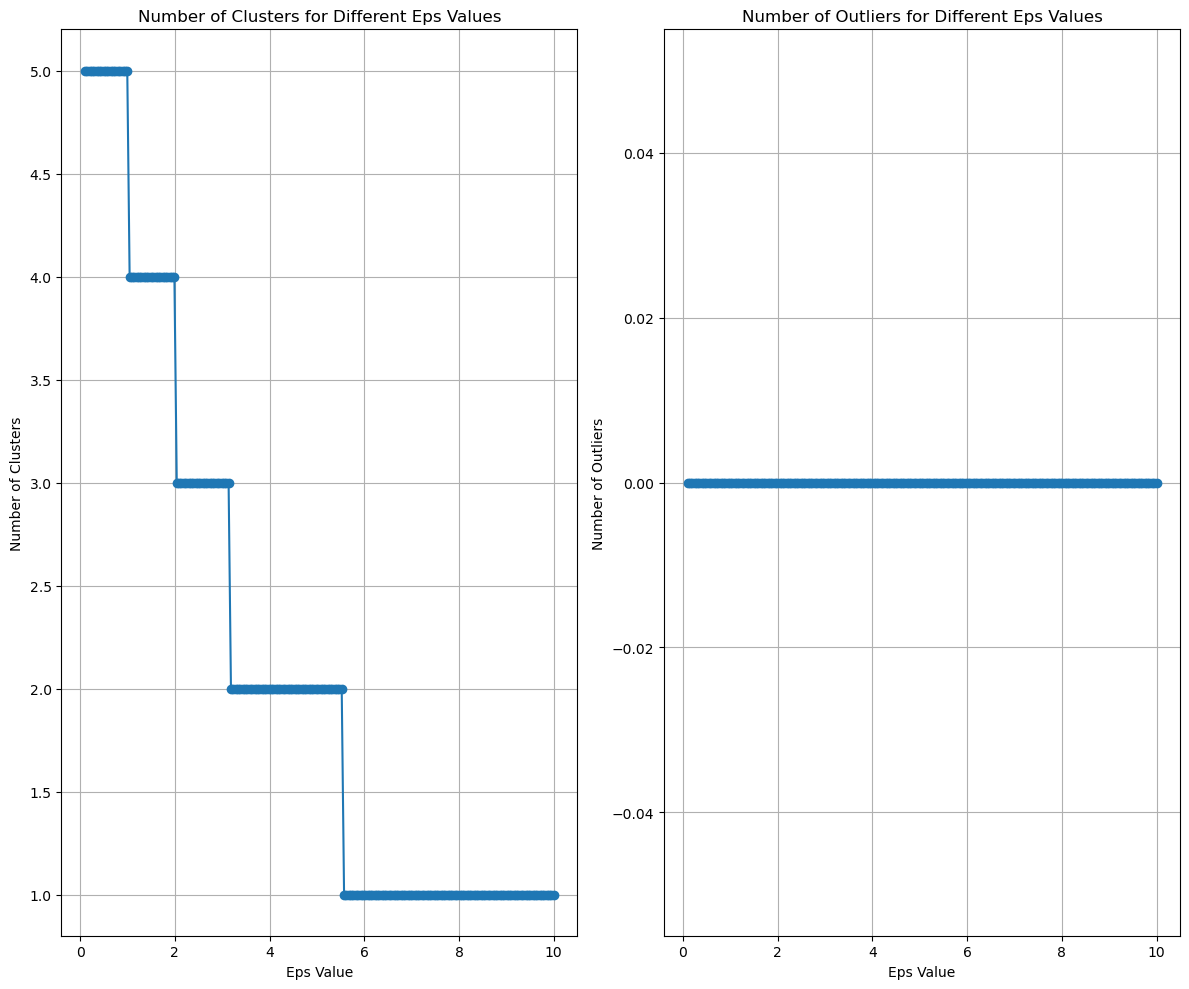

In [792]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, data_qa, 1)

In [798]:
dbscan = DBSCAN(eps=1, min_samples=1)
dbscan.fit(data_qa)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 4


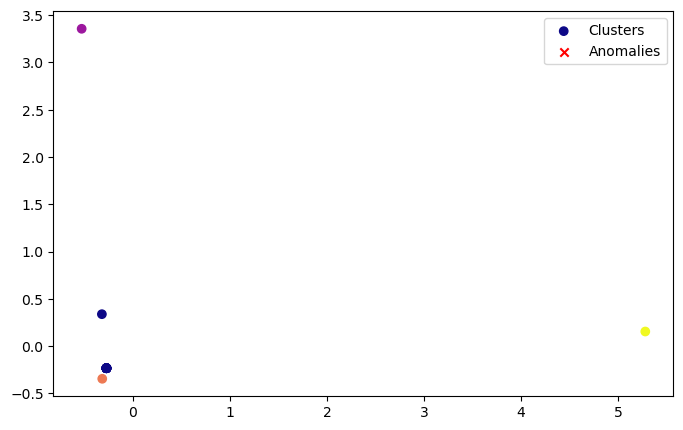

In [799]:
draw_clusters(data_qa, cluster_labels, is_anomaly)

Кластер 0: 16 точек
Кластер 1: 1 точек
Кластер 2: 1 точек
Кластер 3: 1 точек


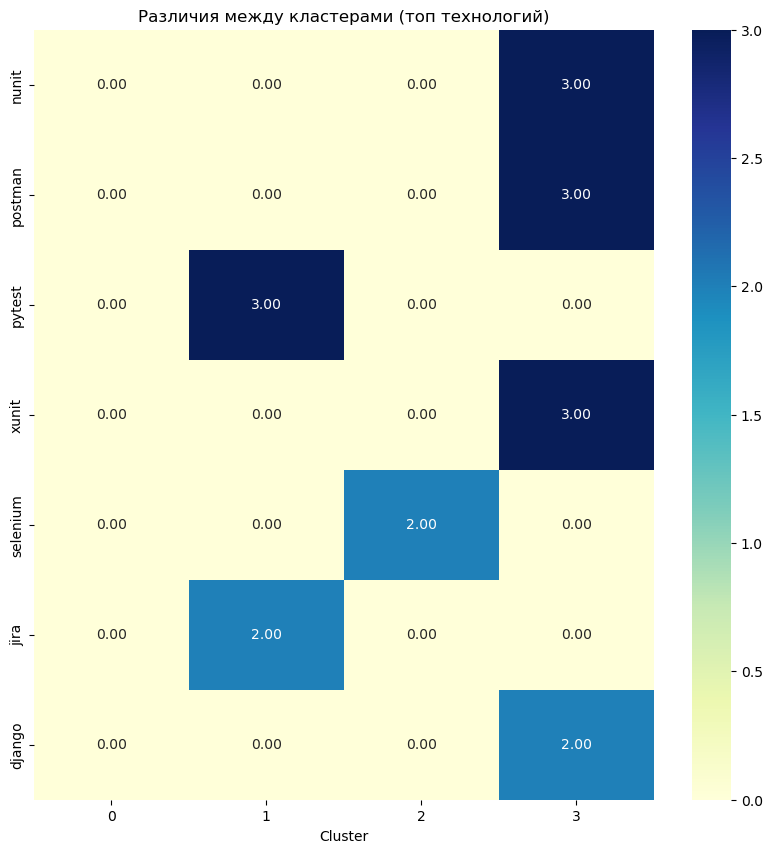

In [801]:
count_points_in_clusters(cluster_labels)
draw_heat_map(data_qa, qa_df.columns, cluster_labels, 30) 

Вывод: nunit, postman, pytest, xunit, selenium
Нужно рассмотреть большее количество точек (>=4)

# Выводы

1. На ПМ-ПУ знают Python и С++ (Джентельменский набор: C++, Python, Numpy, VS Code, Git, Docker)

2. 
    * 'implementation': 
    * 'ux/ui':
    * 'backend developer'
    * 'system or business analyst'
    * 'qa'
    * 'frontend developer'
    * 'da or de'
    * 'pm'